# **Prevedere se un cancro al seno è benigno o maligno**

L'obiettivo è quello di allenare un modello classificatore basandosi su un dataset di caratteristiche di cellule cancerose per predire se una data cellula appartiene ad un tumore benigno o maligno.

Il dataset è stato creato dalla University of Wisconsin. Ha preso in esame 569 casi (righe - campioni) e 32 attributi (colonne - caratteristiche).

## **1. Informazioni sul dataset e comprensione**

### Per quale motivo si è scelto di fare un'analisi del genere?




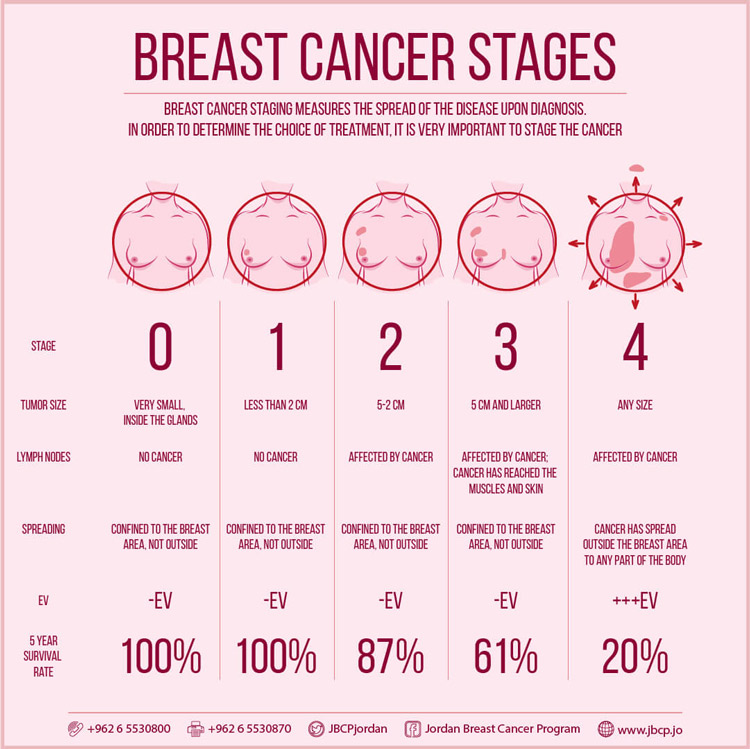

# Dataset

I parametri in esame sono stati ricavati da immagini digitalizzate di campioni di noduli al seno prelevati con agobiopsia. Descrivono le caratteristiche dei nuclei cellulari presenti in ogni immagine.

(Agobiopsia = procedura diagnostica con cui si preleva con un ago sottile un campione di massa sospetta per essere patologica, al fine di analizzarlo al micorscopio in laboratorio)

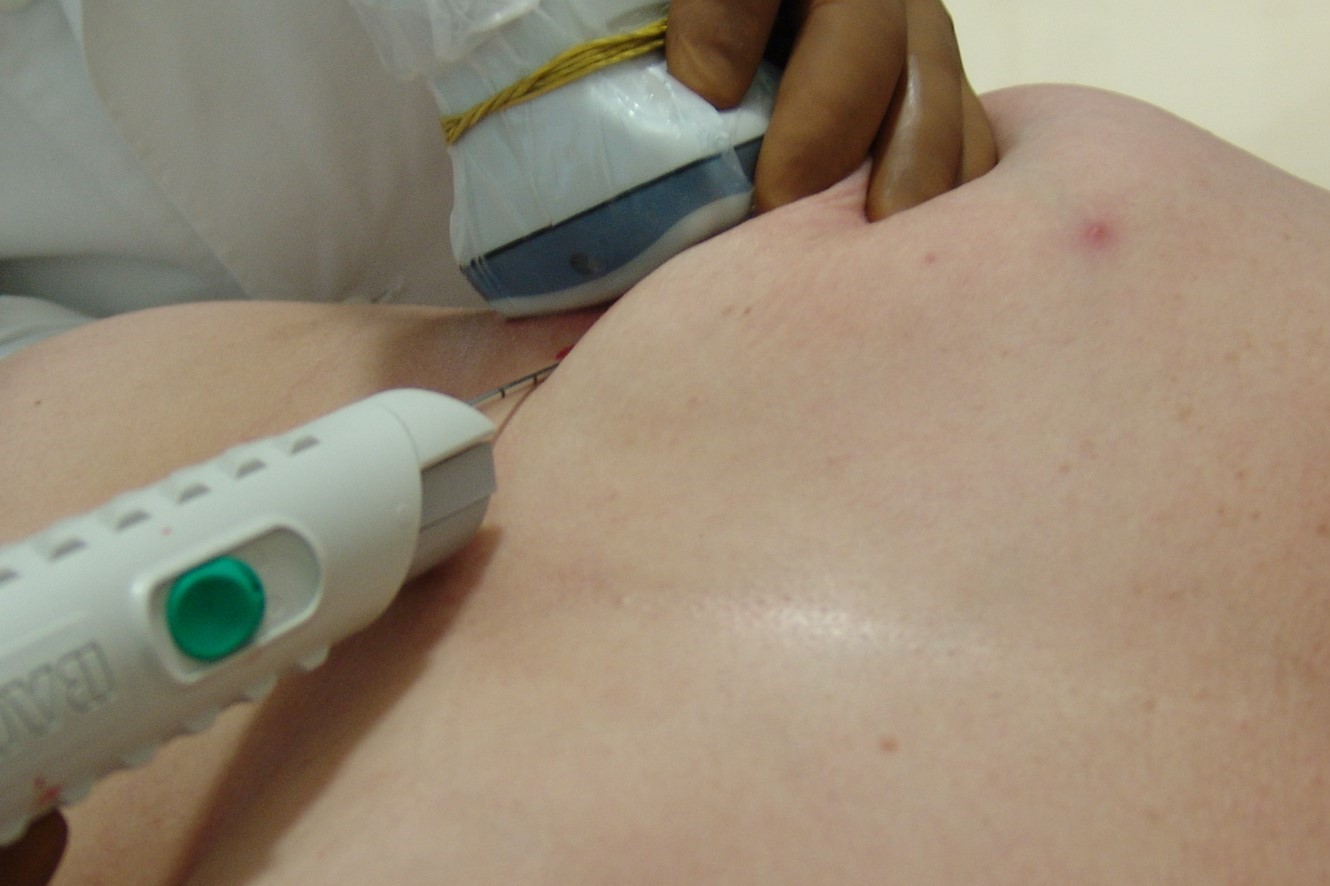

Informazioni sugli attributi del dataset:


1) ID number

2) Diagnosis (M = Malignant; B = Benign)

3-32) Dieci caratteristiche ricavate per ogni nucleo cellulare:
- radius (media delle distanze dei punti del perimetro dal centro);
- texture;
- perimeter;
- area;
- smoothness (variazione locale della lunghezza del raggio);
- compactness (perimetro^2 / area - 1);
- concavity (entità delle porzioni concave del bordo);
- concavity points (numero di porzioni concave del bordo);
- simmetry;
- fractal dimension ("coastline approximation" - 1, è il grado di irregolarità e frammentazione).

Per ogni immagine, sono stati calcolati "mean" (media), "se" (standard error) e "worst" (media dei 3 valori più grandi) di ogni parametro. Il risultato è che sono presenti 30 caratteristiche.
Ad esempio, alla colonna n°2 troviamo "radius_mean", alla 12 "radius_se" ed alla 22 "radius_worst".

Ogni attributo è indicato con quattro cifre significative.



## **2. Importare le librerie necessarie**

In [ ]:
# @title Default title text
import pandas as pd
import numpy as np
import seaborn as sns
import matplotlib.pyplot as plt
from scipy import stats
from sklearn.svm import SVC
from sklearn.preprocessing import LabelEncoder, StandardScaler
from sklearn.model_selection import train_test_split, learning_curve, StratifiedKFold, GridSearchCV, cross_val_score, KFold
#from keras.wrappers.scikit_learn import KerasClassifier
from keras.models import Sequential, load_model
from keras.layers import Dense
from sklearn.metrics import confusion_matrix, make_scorer, accuracy_score, classification_report, roc_curve, auc, precision_score, recall_score, f1_score
from sklearn.linear_model import LogisticRegression
from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from urllib.request import urlopen
from sklearn.neighbors import KNeighborsClassifier, NeighborhoodComponentsAnalysis
from sklearn.naive_bayes import GaussianNB
from sklearn.tree import DecisionTreeClassifier
from sklearn import tree, datasets, svm, metrics
import graphviz
import tensorflow as tf
from tensorflow import keras
from scipy.stats import ttest_ind

from sklearn.decomposition import PCA
import warnings
warnings.filterwarnings("ignore")

import plotly.offline as pyo
import plotly.graph_objs as go
import plotly.figure_factory as ff
from matplotlib.colors import ListedColormap


plt.style.use('ggplot')
pd.set_option('display.max_columns', 500)



## **3. Caricare il dataset**

Il dataset va scaricato in locale e caricato tramite il comando sottostante. Il file da scaricare è presente al sito: https://www.kaggle.com/datasets/uciml/breast-cancer-wisconsin-data?resource=download

In [1]:
from google.colab import files
uploaded = files.upload()

Saving data.csv to data.csv


In [ ]:
'''
import io
data = pd.read_csv(io.BytesIO(uploaded['data.csv']))
data = pd.read_csv('data.csv')
'''

"\nimport io\ndata = pd.read_csv(io.BytesIO(uploaded['data.csv']))\ndata = pd.read_csv('data.csv')\n"

In [ ]:
data = pd.read_csv('data.csv')

quest'ultimo comando crea una copia del dataset, che useremo per lavorare sui violin plot

## **4. Osserviamo i dati**

In [ ]:
data.head()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0    842302         M        17.99         10.38          122.80     1001.0   
1    842517         M        20.57         17.77          132.90     1326.0   
2  84300903         M        19.69         21.25          130.00     1203.0   
3  84348301         M        11.42         20.38           77.58      386.1   
4  84358402         M        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  Unnamed: 32  
0                  0.11890          NaN  
1                  0.08902          NaN  
2                  0.08758          NaN  
3                  0.17300          NaN  
4                  0.07678          NaN

In [ ]:
data.tail()

id diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
564  926424         M        21.56         22.39          142.00     1479.0   
565  926682         M        20.13         28.25          131.20     1261.0   
566  926954         M        16.60         28.08          108.30      858.1   
567  927241         M        20.60         29.33          140.10     1265.0   
568   92751         B         7.76         24.54           47.92      181.0   

     smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
564          0.11100           0.11590         0.24390              0.13890   
565          0.09780           0.10340         0.14400              0.09791   
566          0.08455           0.10230         0.09251              0.05302   
567          0.11780           0.27700         0.35140              0.15200   
568          0.05263           0.04362         0.00000              0.00000   

     symmetry_mean  fractal_dimension_mean  radius_se  texture_se  \
564         0.1726                 0.05623     1.1760       1.256   
565         0.1752                 0.05533     0.7655       2.463   
566         0.1590                 0.05648     0.4564       1.075   
567         0.2397                 0.07016     0.7260       1.595   
568         0.1587                 0.05884     0.3857       1.428   

     perimeter_se  area_se  smoothness_se  compactness_se  concavity_se  \
564         7.673   158.70       0.010300         0.02891       0.05198   
565         5.203    99.04       0.005769         0.02423       0.03950   
566         3.425    48.55       0.005903         0.03731       0.04730   
567         5.772    86.22       0.006522         0.06158       0.07117   
568         2.548    19.15       0.007189         0.00466       0.00000   

     concave points_se  symmetry_se  fractal_dimension_se  radius_worst  \
564            0.02454      0.01114              0.004239        25.450   
565            0.01678      0.01898              0.002498        23.690   
566            0.01557      0.01318              0.003892        18.980   
567            0.01664      0.02324              0.006185        25.740   
568            0.00000      0.02676              0.002783         9.456   

     texture_worst  perimeter_worst  area_worst  smoothness_worst  \
564          26.40           166.10      2027.0           0.14100   
565          38.25           155.00      1731.0           0.11660   
566          34.12           126.70      1124.0           0.11390   
567          39.42           184.60      1821.0           0.16500   
568          30.37            59.16       268.6           0.08996   

     compactness_worst  concavity_worst  concave points_worst  symmetry_worst  \
564            0.21130           0.4107                0.2216          0.2060   
565            0.19220           0.3215                0.1628          0.2572   
566            0.30940           0.3403                0.1418          0.2218   
567            0.86810           0.9387                0.2650          0.4087   
568            0.06444           0.0000                0.0000          0.2871   

     fractal_dimension_worst  Unnamed: 32  
564                  0.07115          NaN  
565                  0.06637          NaN  
566                  0.07820          NaN  
567                  0.12400          NaN  
568                  0.07039          NaN

In [ ]:
data.info()

<class 'pandas.core.frame.DataFrame'>
RangeIndex: 569 entries, 0 to 568
Data columns (total 33 columns):
 #   Column                   Non-Null Count  Dtype  
---  ------                   --------------  -----  
 0   id                       569 non-null    int64  
 1   diagnosis                569 non-null    object 
 2   radius_mean              569 non-null    float64
 3   texture_mean             569 non-null    float64
 4   perimeter_mean           569 non-null    float64
 5   area_mean                569 non-null    float64
 6   smoothness_mean          569 non-null    float64
 7   compactness_mean         569 non-null    float64
 8   concavity_mean           569 non-null    float64
 9   concave points_mean      569 non-null    float64
 10  symmetry_mean            569 non-null    float64
 11  fractal_dimension_mean   569 non-null    float64
 12  radius_se                569 non-null    float64
 13  texture_se               569 non-null    float64
 14  perimeter_se             5

Ci accorgiamo che esiste una colonna "Unnamed: 32" che contiene valori nulli: andiamo ad eliminarla. Eliminiamo anche la colonna che contiene gli ID dei campioni, non è utile per classificare i dati.

"diagnosis" è la nostra class label, ossia l'attributo di cui vogliamo andare a predire il valore in base agli altri attributi.

Notiamo anche che i restanti dati sono tutti in formato float, ad eccezione della diagnosi, che andiamo a convertire:

In [ ]:
data = data.drop(['Unnamed: 32','id'],axis = 1)
data["diagnosis"] = data["diagnosis"].map({"M":1, "B":0})

In [ ]:
data_save=data

ci salviamo il df pulito in una variabile per poterlo recuperare più tardi e lavorare più facilmente

Stampiamo nuovamente le prime 5 righe (head) per osservare i dati.

In [ ]:
data.head()

diagnosis  radius_mean  texture_mean  perimeter_mean  area_mean  \
0          1        17.99         10.38          122.80     1001.0   
1          1        20.57         17.77          132.90     1326.0   
2          1        19.69         21.25          130.00     1203.0   
3          1        11.42         20.38           77.58      386.1   
4          1        20.29         14.34          135.10     1297.0   

   smoothness_mean  compactness_mean  concavity_mean  concave points_mean  \
0          0.11840           0.27760          0.3001              0.14710   
1          0.08474           0.07864          0.0869              0.07017   
2          0.10960           0.15990          0.1974              0.12790   
3          0.14250           0.28390          0.2414              0.10520   
4          0.10030           0.13280          0.1980              0.10430   

   symmetry_mean  fractal_dimension_mean  radius_se  texture_se  perimeter_se  \
0         0.2419                 0.07871     1.0950      0.9053         8.589   
1         0.1812                 0.05667     0.5435      0.7339         3.398   
2         0.2069                 0.05999     0.7456      0.7869         4.585   
3         0.2597                 0.09744     0.4956      1.1560         3.445   
4         0.1809                 0.05883     0.7572      0.7813         5.438   

   area_se  smoothness_se  compactness_se  concavity_se  concave points_se  \
0   153.40       0.006399         0.04904       0.05373            0.01587   
1    74.08       0.005225         0.01308       0.01860            0.01340   
2    94.03       0.006150         0.04006       0.03832            0.02058   
3    27.23       0.009110         0.07458       0.05661            0.01867   
4    94.44       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  
0                  0.11890  
1                  0.08902  
2                  0.08758  
3                  0.17300  
4                  0.07678

Controlliamo se ci sono valori mancanti di cui occuparci:

In [ ]:
def num_missing(x):
  return sum(x.isnull())

print("Missing values per column:")
print(data.apply(num_missing, axis=0)) #axis=0 defines that function is to be applied on each column

Missing values per column:
diagnosis                  0
radius_mean                0
texture_mean               0
perimeter_mean             0
area_mean                  0
smoothness_mean            0
compactness_mean           0
concavity_mean             0
concave points_mean        0
symmetry_mean              0
fractal_dimension_mean     0
radius_se                  0
texture_se                 0
perimeter_se               0
area_se                    0
smoothness_se              0
compactness_se             0
concavity_se               0
concave points_se          0
symmetry_se                0
fractal_dimension_se       0
radius_worst               0
texture_worst              0
perimeter_worst            0
area_worst                 0
smoothness_worst           0
compactness_worst          0
concavity_worst            0
concave points_worst       0
symmetry_worst             0
fractal_dimension_worst    0
dtype: int64


Stampiamo una tabella con tutti i dati numerici e osserviamo le statistiche sui dati.

In [ ]:
data.describe().T

count        mean         std         min  \
diagnosis                569.0    0.372583    0.483918    0.000000   
radius_mean              569.0   14.127292    3.524049    6.981000   
texture_mean             569.0   19.289649    4.301036    9.710000   
perimeter_mean           569.0   91.969033   24.298981   43.790000   
area_mean                569.0  654.889104  351.914129  143.500000   
smoothness_mean          569.0    0.096360    0.014064    0.052630   
compactness_mean         569.0    0.104341    0.052813    0.019380   
concavity_mean           569.0    0.088799    0.079720    0.000000   
concave points_mean      569.0    0.048919    0.038803    0.000000   
symmetry_mean            569.0    0.181162    0.027414    0.106000   
fractal_dimension_mean   569.0    0.062798    0.007060    0.049960   
radius_se                569.0    0.405172    0.277313    0.111500   
texture_se               569.0    1.216853    0.551648    0.360200   
perimeter_se             569.0    2.866059    2.021855    0.757000   
area_se                  569.0   40.337079   45.491006    6.802000   
smoothness_se            569.0    0.007041    0.003003    0.001713   
compactness_se           569.0    0.025478    0.017908    0.002252   
concavity_se             569.0    0.031894    0.030186    0.000000   
concave points_se        569.0    0.011796    0.006170    0.000000   
symmetry_se              569.0    0.020542    0.008266    0.007882   
fractal_dimension_se     569.0    0.003795    0.002646    0.000895   
radius_worst             569.0   16.269190    4.833242    7.930000   
texture_worst            569.0   25.677223    6.146258   12.020000   
perimeter_worst          569.0  107.261213   33.602542   50.410000   
area_worst               569.0  880.583128  569.356993  185.200000   
smoothness_worst         569.0    0.132369    0.022832    0.071170   
compactness_worst        569.0    0.254265    0.157336    0.027290   
concavity_worst          569.0    0.272188    0.208624    0.000000   
concave points_worst     569.0    0.114606    0.065732    0.000000   
symmetry_worst           569.0    0.290076    0.061867    0.156500   
fractal_dimension_worst  569.0    0.083946    0.018061    0.055040   

                                25%         50%          75%         max  
diagnosis                  0.000000    0.000000     1.000000     1.00000  
radius_mean               11.700000   13.370000    15.780000    28.11000  
texture_mean              16.170000   18.840000    21.800000    39.28000  
perimeter_mean            75.170000   86.240000   104.100000   188.50000  
area_mean                420.300000  551.100000   782.700000  2501.00000  
smoothness_mean            0.086370    0.095870     0.105300     0.16340  
compactness_mean           0.064920    0.092630     0.130400     0.34540  
concavity_mean             0.029560    0.061540     0.130700     0.42680  
concave points_mean        0.020310    0.033500     0.074000     0.20120  
symmetry_mean              0.161900    0.179200     0.195700     0.30400  
fractal_dimension_mean     0.057700    0.061540     0.066120     0.09744  
radius_se                  0.232400    0.324200     0.478900     2.87300  
texture_se                 0.833900    1.108000     1.474000     4.88500  
perimeter_se               1.606000    2.287000     3.357000    21.98000  
area_se                   17.850000   24.530000    45.190000   542.20000  
smoothness_se              0.005169    0.006380     0.008146     0.03113  
compactness_se             0.013080    0.020450     0.032450     0.13540  
concavity_se               0.015090    0.025890     0.042050     0.39600  
concave points_se          0.007638    0.010930     0.014710     0.05279  
symmetry_se                0.015160    0.018730     0.023480     0.07895  
fractal_dimension_se       0.002248    0.003187     0.004558     0.02984  
radius_worst              13.010000   14.970000    18.790000    36.04000  
texture_worst             21.080000   25.410000    29.72000

## **5. Relazioni tra le variabili**

### Scatter plot

È il modo più semplice per studiare la relazione tra variabili.

Osserviamo per esempio se esiste una relazione tra il raggio medio e l'area media.

<Figure size 1500x1000 with 0 Axes>

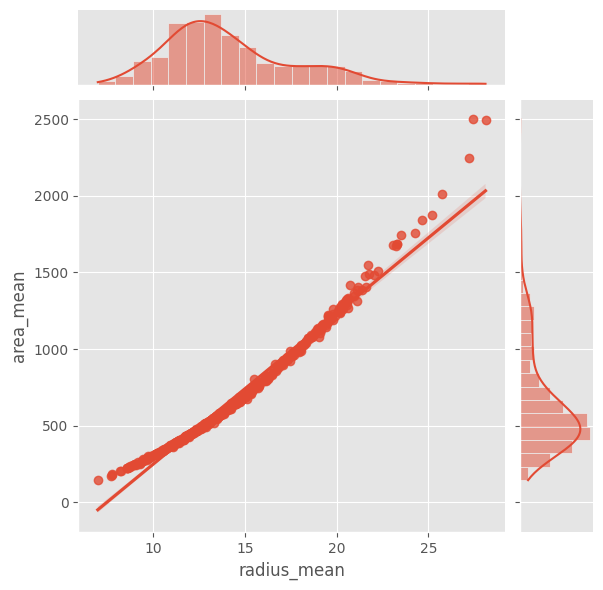

In [ ]:
data = data_save
plt.figure(figsize=(15, 10))
sns.jointplot(x='radius_mean', y='area_mean', data=data, kind='reg')
plt.show()

Ovviamente possiamo osservare una correlazione: quando il raggio medio aumenta, aumenta anche l'area media. Perciò c'è una correlazione positiva tra i due.

<Figure size 1500x1000 with 0 Axes>

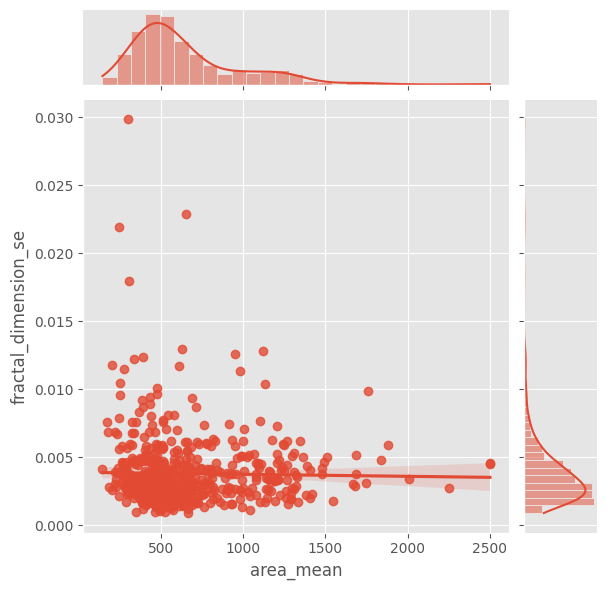

In [ ]:
plt.figure(figsize = (15,10))
sns.jointplot(x='area_mean', y='fractal_dimension_se', data=data, kind="reg")
plt.show()


Al contrario, notiamo che non esiste correlazione tra area media e standard error della dimensione frattale: lo standard error della dimensione frattale non è influenzato dal variare dell'area.

### **Scatter Plot totali**

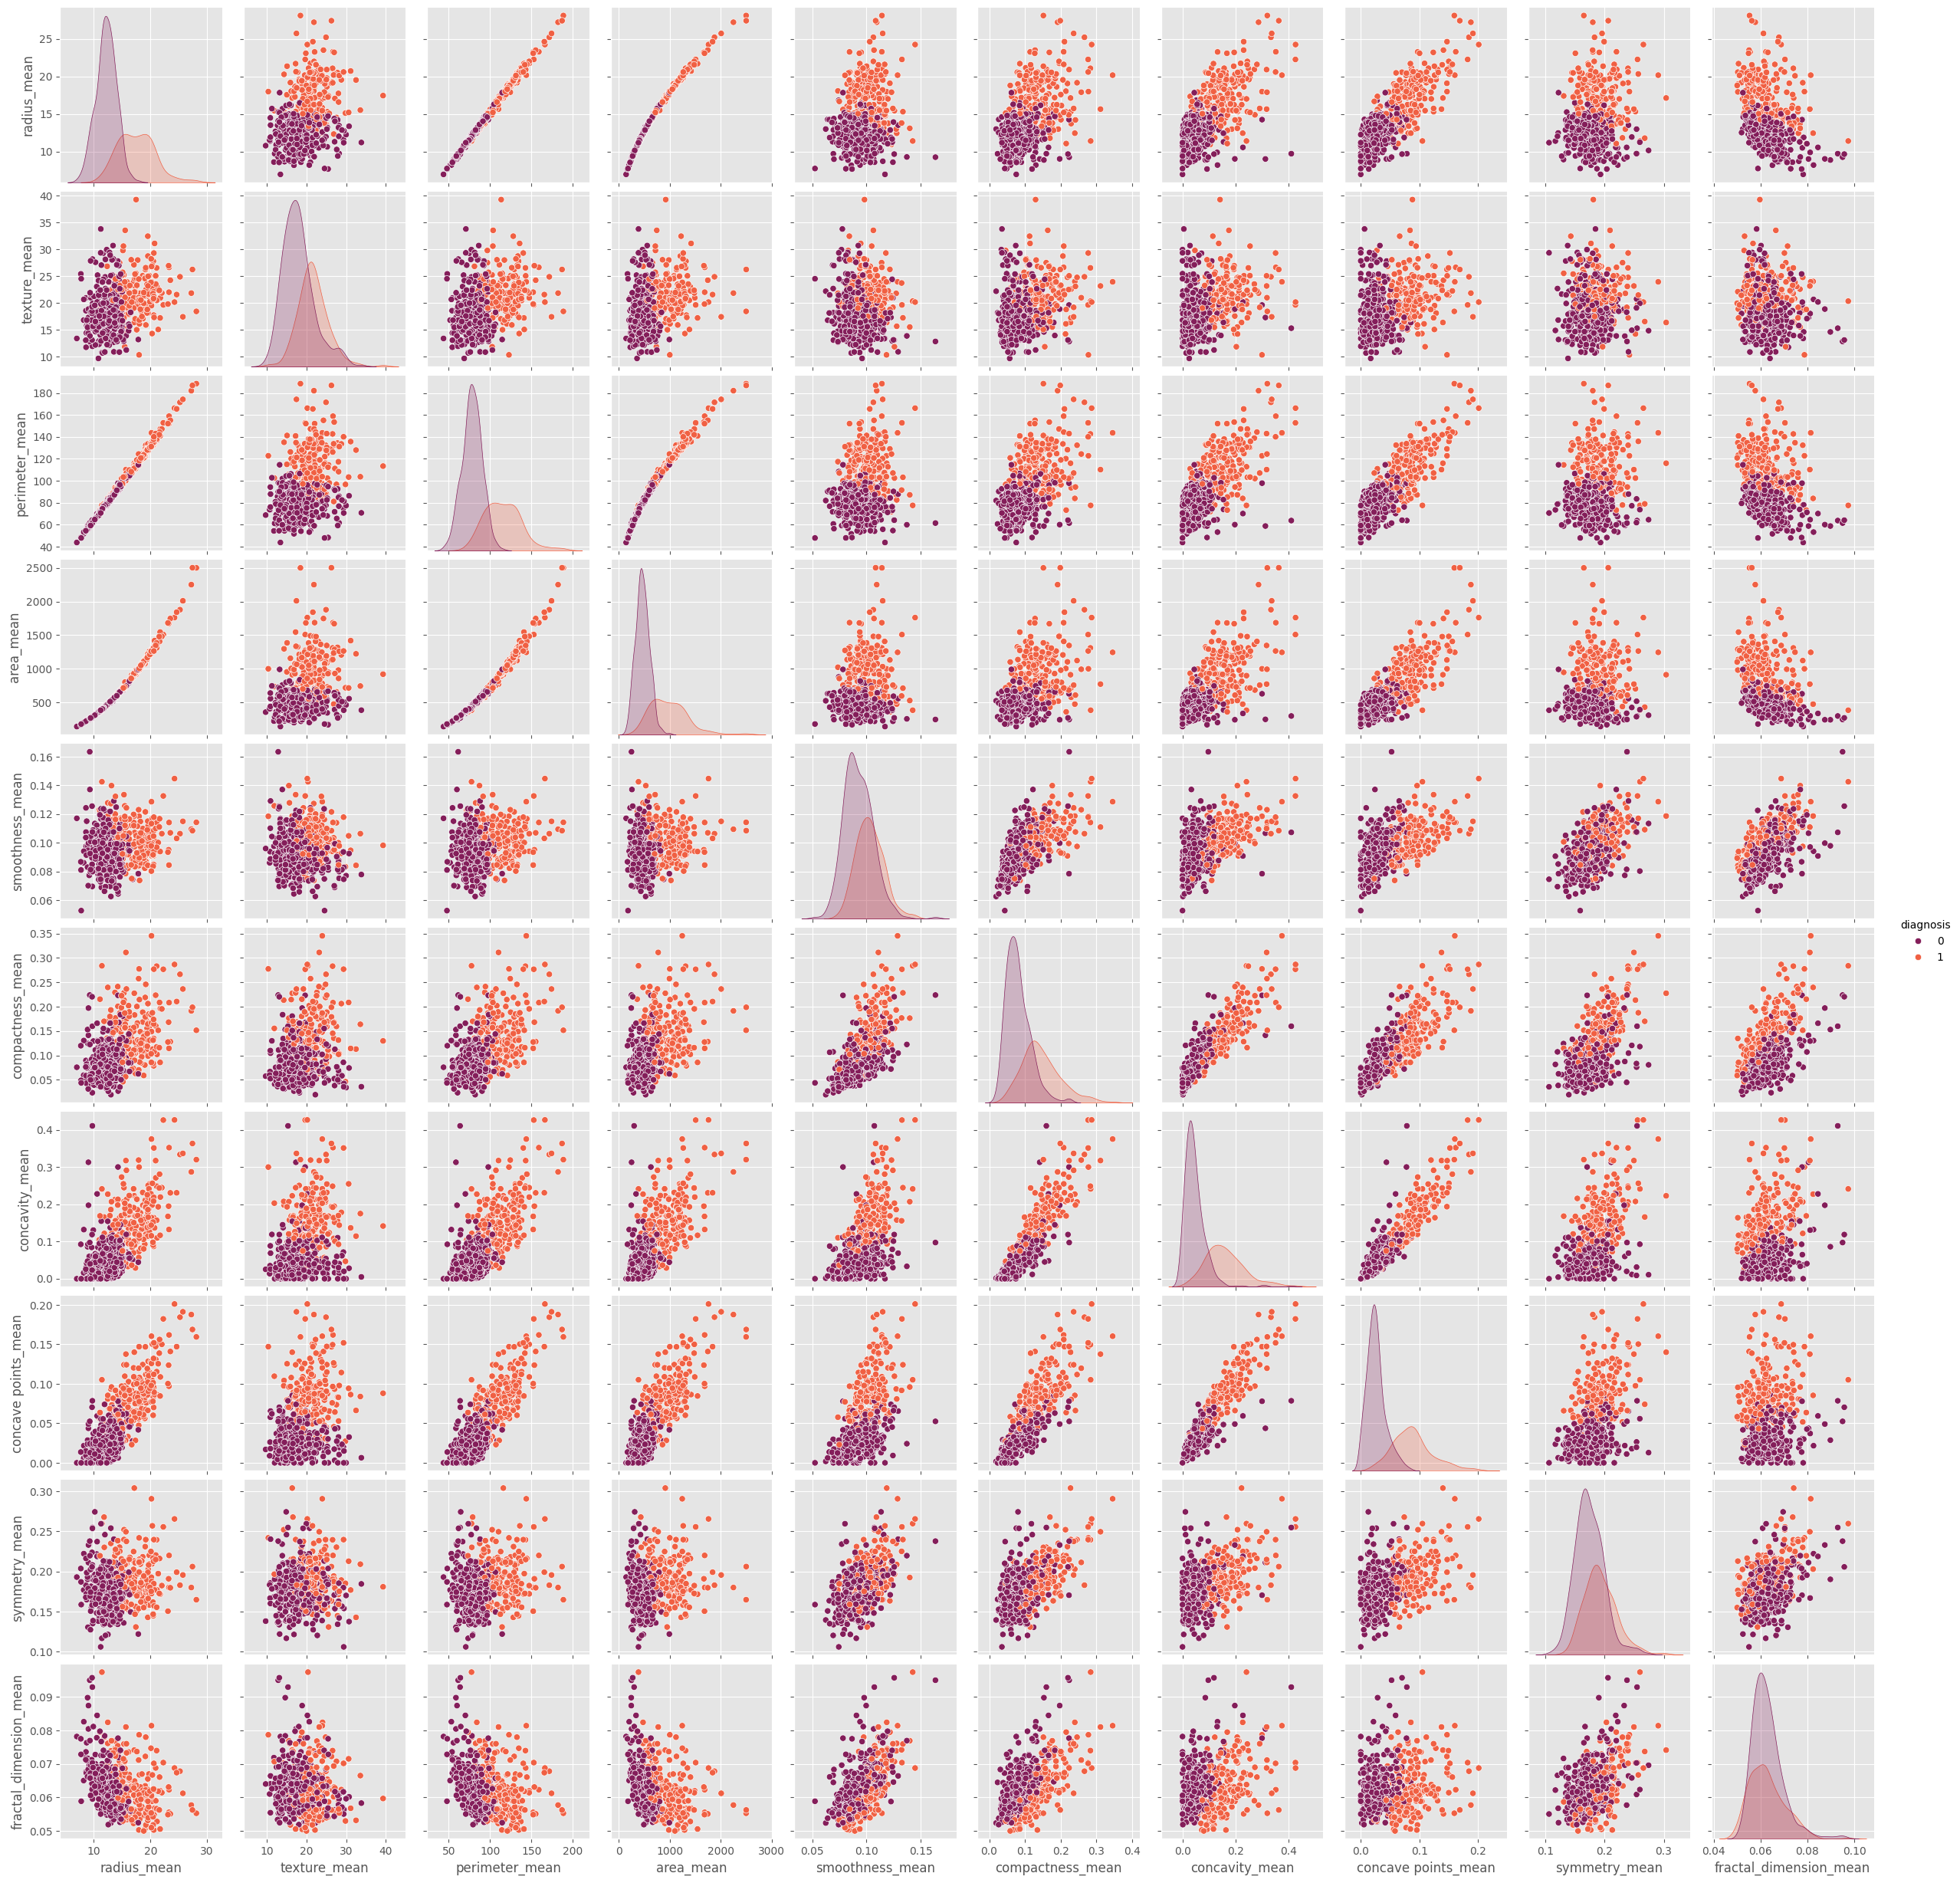

In [ ]:
#generiamo un grafico a dispersione con le sole colonne "mean"
cols = ['diagnosis',
        'radius_mean',
        'texture_mean',
        'perimeter_mean',
        'area_mean',
        'smoothness_mean',
        'compactness_mean',
        'concavity_mean',
        'concave points_mean',
        'symmetry_mean',
        'fractal_dimension_mean']

sns.pairplot(data=data[cols], hue='diagnosis', palette='rocket')


Ci sono pattern lineari quasi perfetti tra raggio, perimetro e area. Ciò indicano la presenza di una multicollinearità tra queste variabili (cioè sono strettamente correlate in modo lineare). Un altro set di variabili che potrebbe implicare multicollinearità sono la concavità, i punti di concavità e la compattezza.

La multicollinearità è un problema, poiché potrebbe minare la significatività delle variabili indipendenti. Interveniamo rimuovendo i predittori altamente correlati dal modello.

### **Matrice di correlazione**

Possiamo esaminare la forza delle relazioni tra coppie di variabili.
Diciamo che due variabili sono in relazione tra loro, se l'una ci dà informazioni sull'altra.  

Osserviamo nella matrice la correlazione tra tutte le caratteristiche a disposizione.
Il range dei numeri ottenibili spazia da 1 (massimo della correlazione positiva tra due variabili) e -1 (massimo della correlazione negativa tra due variabili). Un valore di 0 indica che non esiste correlazione tra le due variabili.

In [ ]:
data.corr()

diagnosis  radius_mean  texture_mean  perimeter_mean  \
diagnosis                 1.000000     0.730029      0.415185        0.742636   
radius_mean               0.730029     1.000000      0.323782        0.997855   
texture_mean              0.415185     0.323782      1.000000        0.329533   
perimeter_mean            0.742636     0.997855      0.329533        1.000000   
area_mean                 0.708984     0.987357      0.321086        0.986507   
smoothness_mean           0.358560     0.170581     -0.023389        0.207278   
compactness_mean          0.596534     0.506124      0.236702        0.556936   
concavity_mean            0.696360     0.676764      0.302418        0.716136   
concave points_mean       0.776614     0.822529      0.293464        0.850977   
symmetry_mean             0.330499     0.147741      0.071401        0.183027   
fractal_dimension_mean   -0.012838    -0.311631     -0.076437       -0.261477   
radius_se                 0.567134     0.679090      0.275869        0.691765   
texture_se               -0.008303    -0.097317      0.386358       -0.086761   
perimeter_se              0.556141     0.674172      0.281673        0.693135   
area_se                   0.548236     0.735864      0.259845        0.744983   
smoothness_se            -0.067016    -0.222600      0.006614       -0.202694   
compactness_se            0.292999     0.206000      0.191975        0.250744   
concavity_se              0.253730     0.194204      0.143293        0.228082   
concave points_se         0.408042     0.376169      0.163851        0.407217   
symmetry_se              -0.006522    -0.104321      0.009127       -0.081629   
fractal_dimension_se      0.077972    -0.042641      0.054458       -0.005523   
radius_worst              0.776454     0.969539      0.352573        0.969476   
texture_worst             0.456903     0.297008      0.912045        0.303038   
perimeter_worst           0.782914     0.965137      0.358040        0.970387   
area_worst                0.733825     0.941082      0.343546        0.941550   
smoothness_worst          0.421465     0.119616      0.077503        0.150549   
compactness_worst         0.590998     0.413463      0.277830        0.455774   
concavity_worst           0.659610     0.526911      0.301025        0.563879   
concave points_worst      0.793566     0.744214      0.295316        0.771241   
symmetry_worst            0.416294     0.163953      0.105008        0.189115   
fractal_dimension_worst   0.323872     0.007066      0.119205        0.051019   

                         area_mean  smoothness_mean  compactness_mean  \
diagnosis                 0.708984         0.358560          0.596534   
radius_mean               0.987357         0.170581          0.506124   
texture_mean              0.321086        -0.023389          0.236702   
perimeter_mean            0.986507         0.207278          0.556936   
area_mean                 1.000000         0.177028          0.498502   
smoothness_mean           0.177028         1.000000          0.659123   
compactness_mean          0.498502         0.659123          1.000000   
concavity_mean            0.685983         0.521984          0.883121   
concave points_mean       0.823269         0.553695          0.831135   
symmetry_mean             0.151293         0.557775          0.602641   
fractal_dimension_mean   -0.283110         0.584792          0.565369   
radius_se                 0.732562         0.301467          0.497473   
texture_se               -0.066280         0.068406          0.046205   
perimeter_se              0.726628         0.296092          0.548905   
area_se                   0.800086         0.246552          0.455653   
smoothness_se            -0.166777         0.332375          0.135299   
compactness_se            0.212583         0.318943          0.738722   
concavity_se              0.207660         0.248396          0.570517   
concave points_se         0.372320         0.

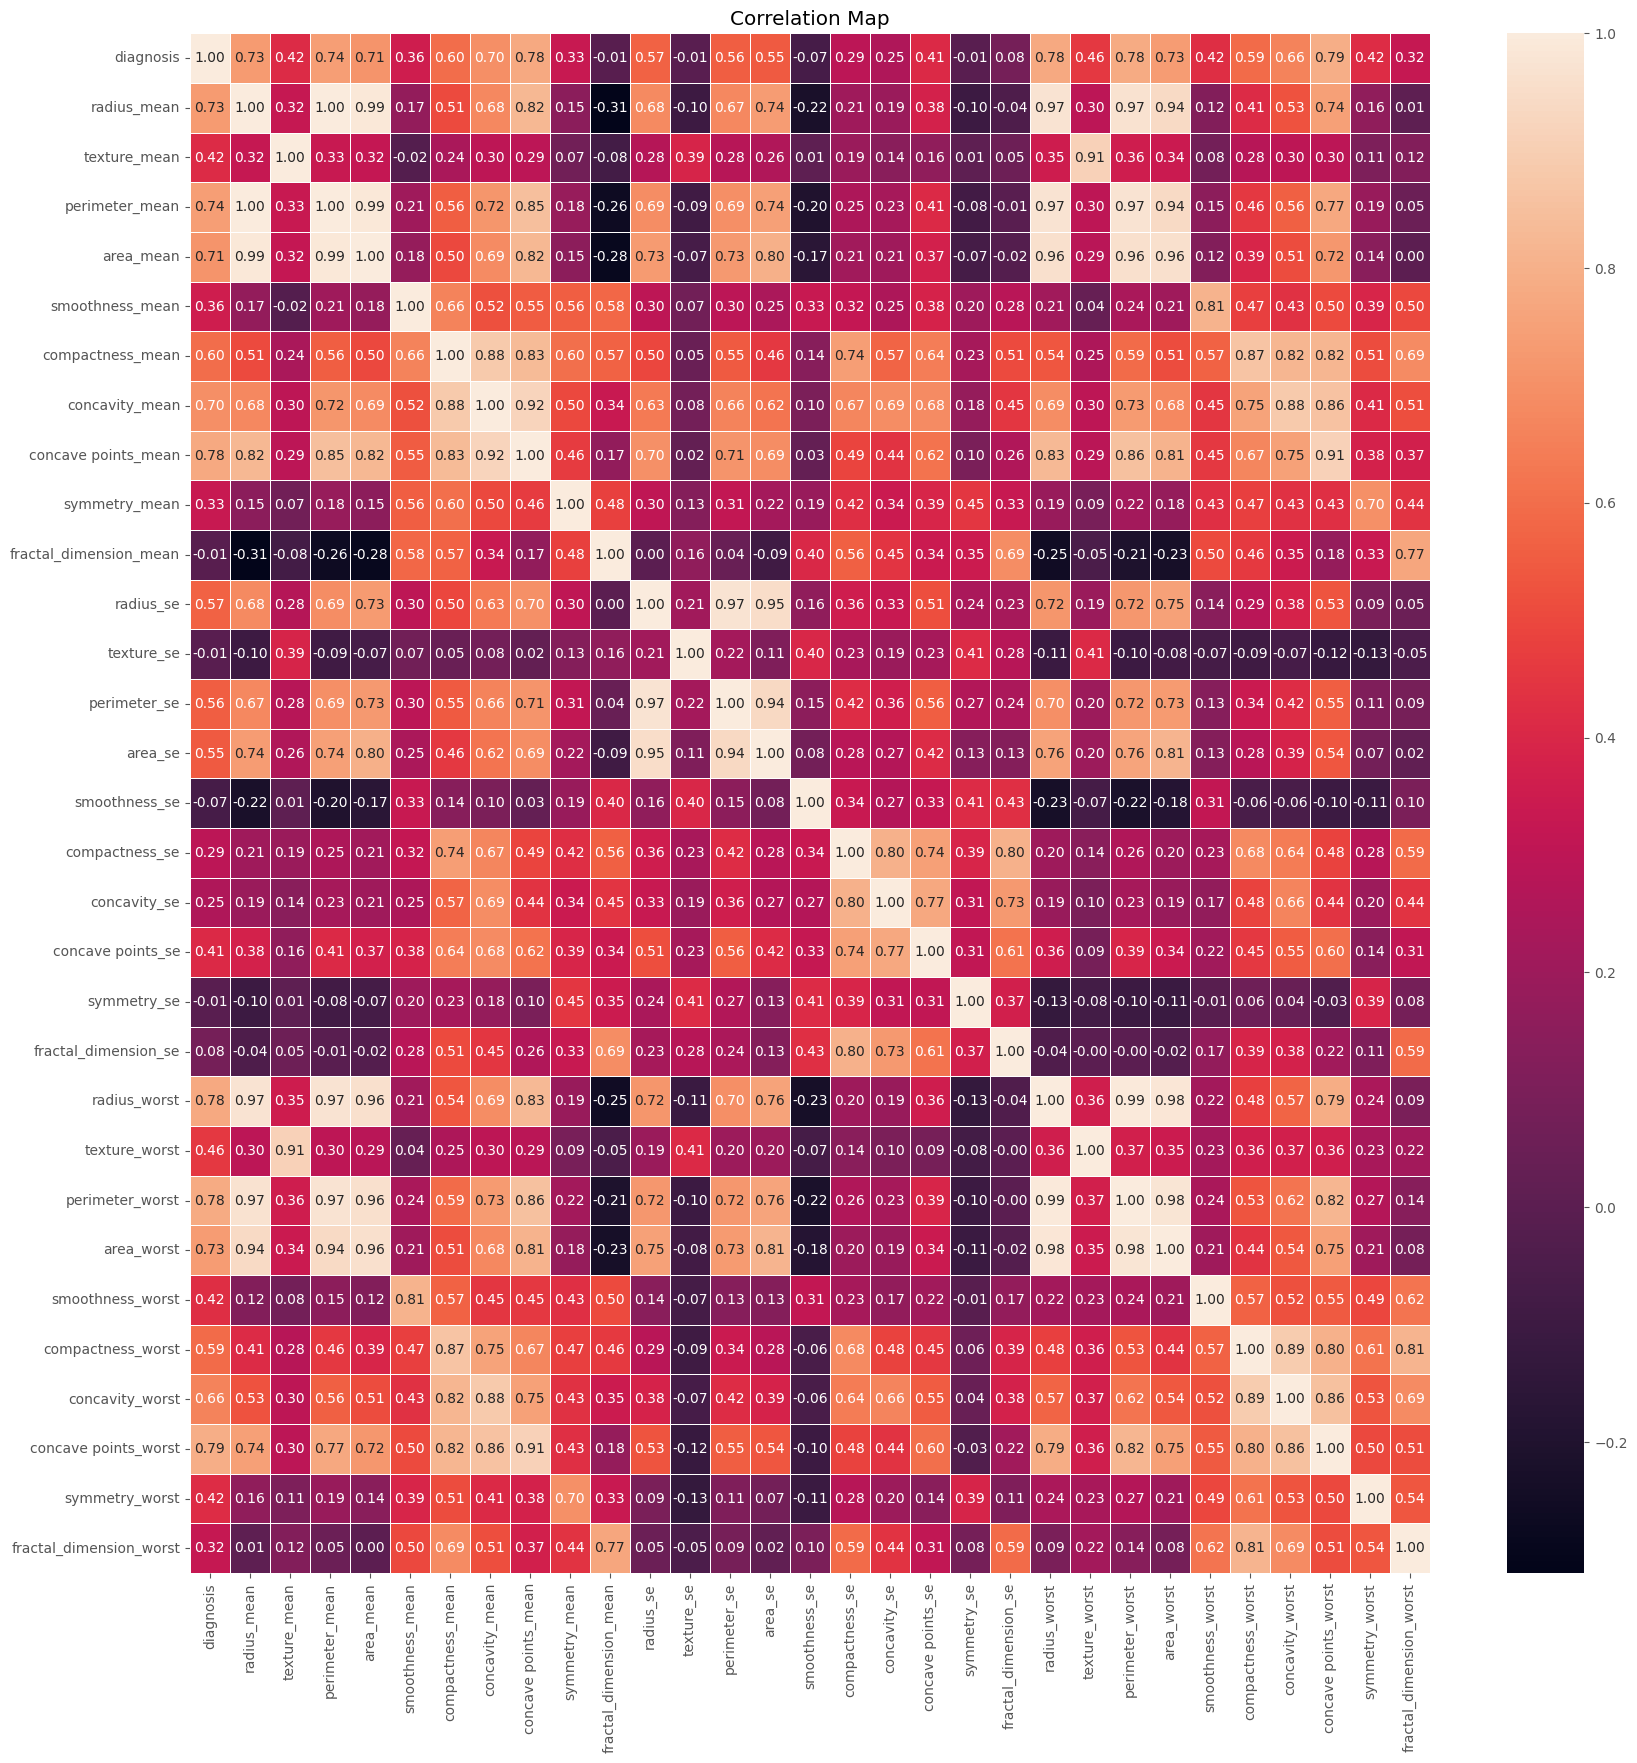

In [ ]:
f,ax=plt.subplots(figsize = (20,20)) #creiamo una figura e un set di assi, stabilendo i parametri con figsize
sns.heatmap(data.corr(),annot= True,linewidths=0.5,fmt = ".2f",ax=ax) #costruiamo un heatmap
plt.xticks(rotation=90) #permette di ruotare le etichette dell'asse x per renderle legibili
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

Possiamo verificare la presenza della multicollinearità tra alcune delle variabili.
Per esempio, il raggio medio ha una correlazione di 1 e 0.99 con periemtro medio e area media, rispettivamente. Ciò è dato dal fatto che le tre colonne essenzialmente contengono la stessa informazione, che è la dimensione fisica di ciò che stiamo osservando (il nucleo cellulare).

Perciò, selezioneremo soltanto una tra queste tre caratteristiche andando avanti con l'analisi.

Si nota multicollinearità anche tra le colonne "mean" e "worst". Per esempio, il raggio medio ha una correlazione di 0.97 con il raggio worst.

Inoltre, c'è mulicollinearità tra gli attributi: compattezza, concavità e punti di concavità. Quindi potremo selezionare solo uno di questi. Scegliamo la compattezza.

In [ ]:
#Prima, elimino tutte le colonne "worst" perchè correlano tutte coi "mean"
cols = ['radius_worst',
        'texture_worst',
        'perimeter_worst',
        'area_worst',
        'smoothness_worst',
        'compactness_worst',
        'concavity_worst',
        'concave points_worst',
        'symmetry_worst',
        'fractal_dimension_worst']
data = data.drop(cols, axis=1)

#dopo, elimino tutte le colonne relative agli attributi perimetro e area perchè ovviamente sono correlati
cols = ['perimeter_mean',
        'perimeter_se',
        'area_mean',
        'area_se']
data = data.drop(cols, axis=1)

#alla fine, droppo tutte le colonne relative agli attributi di concavità e punti concavi perchè correlati con un altra che abbiamo lasciato
cols = ['concavity_mean',
        'concavity_se',
        'concave points_mean',
        'concave points_se']
data = data.drop(cols, axis=1)

data_final = data
#verifico le colonne rimanenti
data.columns

Index(['diagnosis', 'radius_mean', 'texture_mean', 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se'],
      dtype='object')

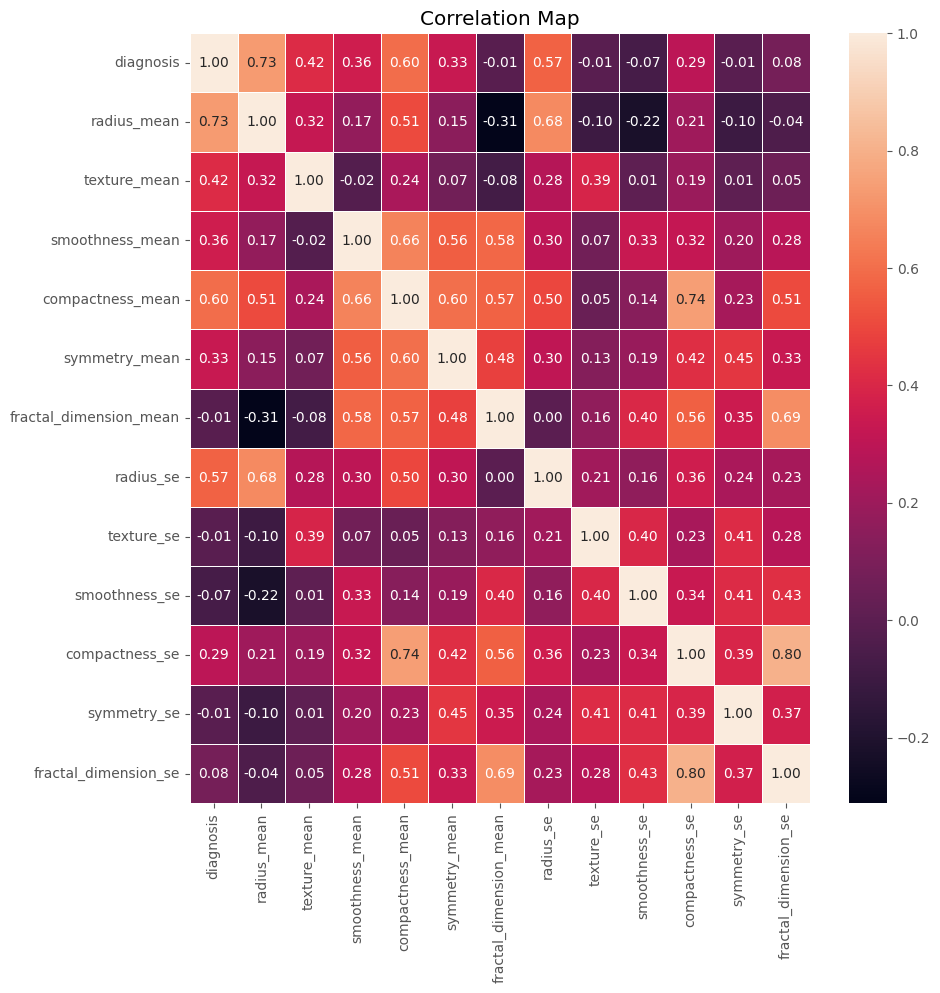

In [ ]:
#Disegno nuovamente un heatmap, contenente la nuova matrice di correlazione
f,ax=plt.subplots(figsize = (10,10))
sns.heatmap(data.corr(),annot= True,linewidths=0.5,fmt = ".2f",ax=ax)
plt.xticks(rotation=90)
plt.yticks(rotation=0)
plt.title('Correlation Map')
plt.show()

## **6. Visualizzazione dei dati**

### **Istogramma**

Andiamo ad osservare la numerosità dei tumori benigni B e maligni M nel dataset.

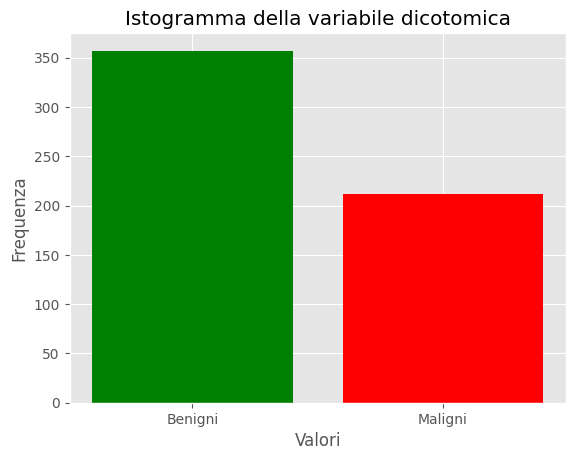

In [ ]:
data = data_save
frequencies = data['diagnosis'].value_counts()

# Creare un istogramma con le frequenze dei valori
plt.bar(frequencies.index, frequencies.values)

colors = ['green', 'red']  # verde per 0, rosso per 1
plt.bar(frequencies.index, frequencies.values, color=colors)

# Etichettare l'asse x con i valori della variabile dicotomica
plt.xticks(frequencies.index, ['Benigni', 'Maligni'])

# Etichettare gli assi x e y e dare un titolo al grafico
plt.xlabel('Valori')
plt.ylabel('Frequenza')
plt.title('Istogramma della variabile dicotomica')

# Mostrare il grafico
plt.show()

In [ ]:
lista = ["radius_mean", "texture_mean", 'smoothness_mean',
       'compactness_mean', 'symmetry_mean', 'fractal_dimension_mean',
       'radius_se', 'texture_se', 'smoothness_se', 'compactness_se',
       'symmetry_se', 'fractal_dimension_se']


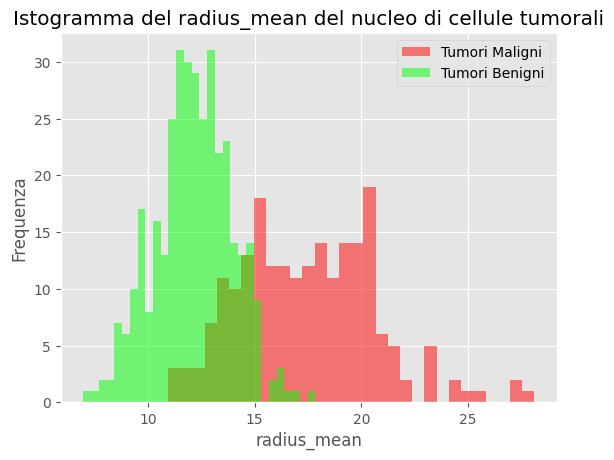

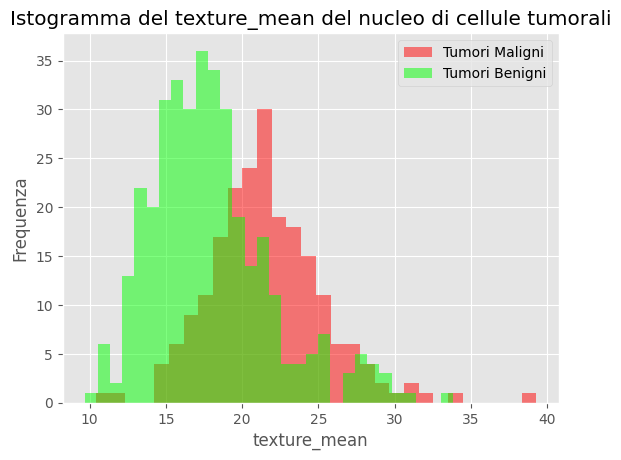

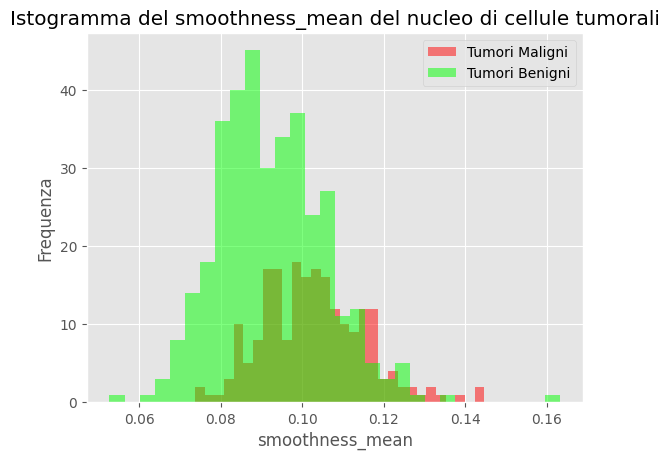

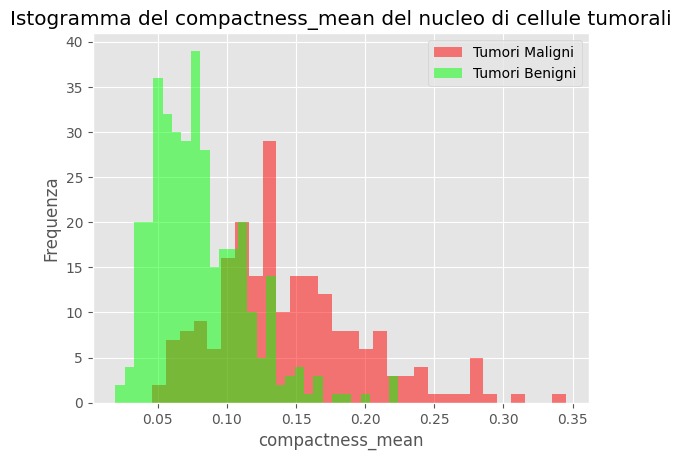

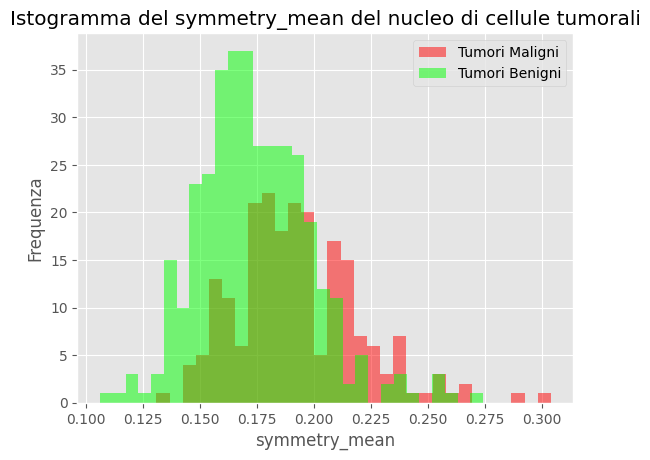

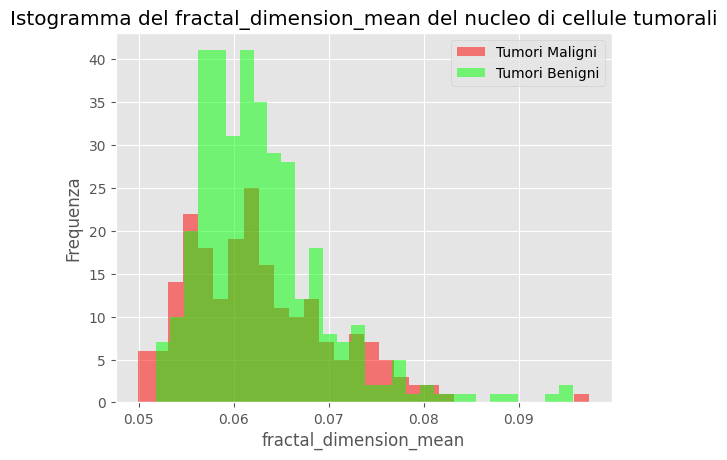

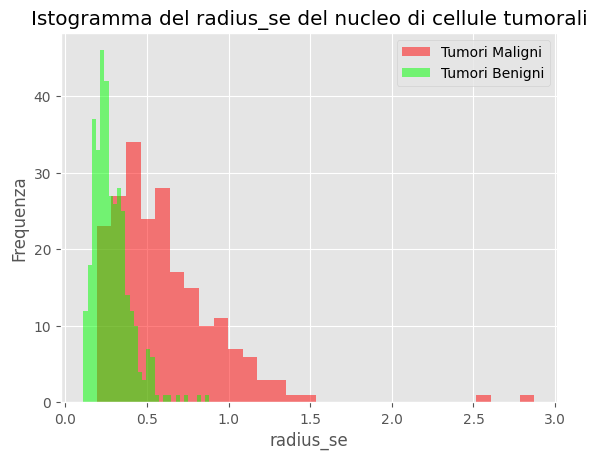

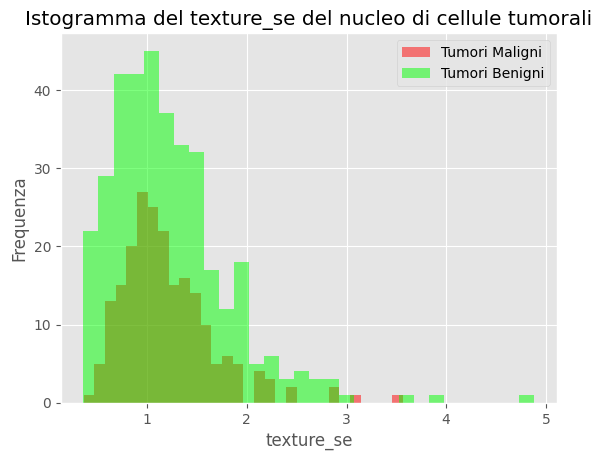

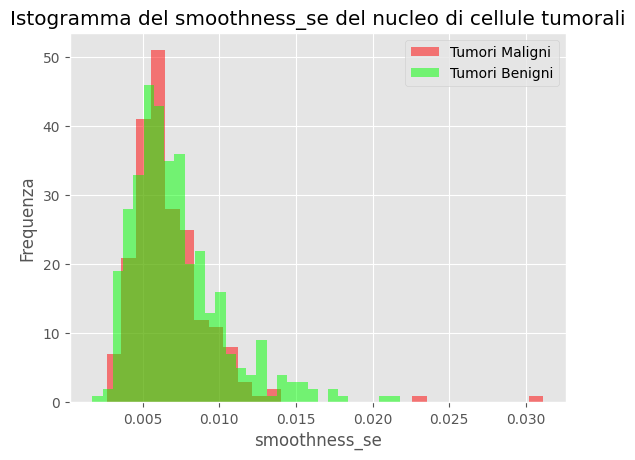

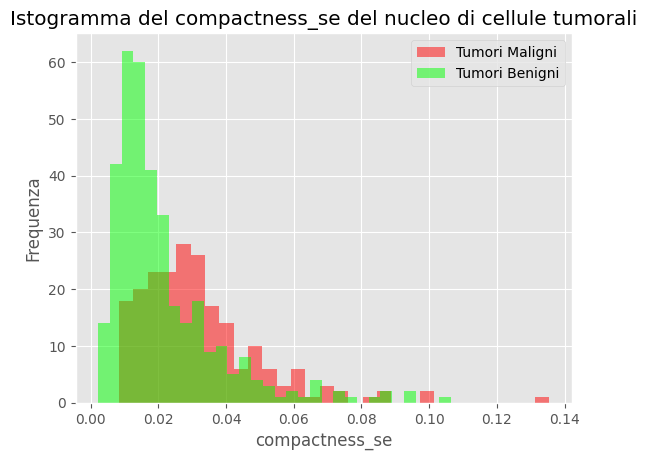

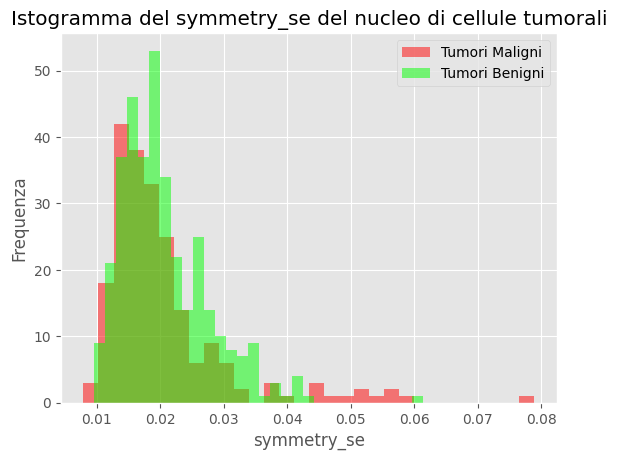

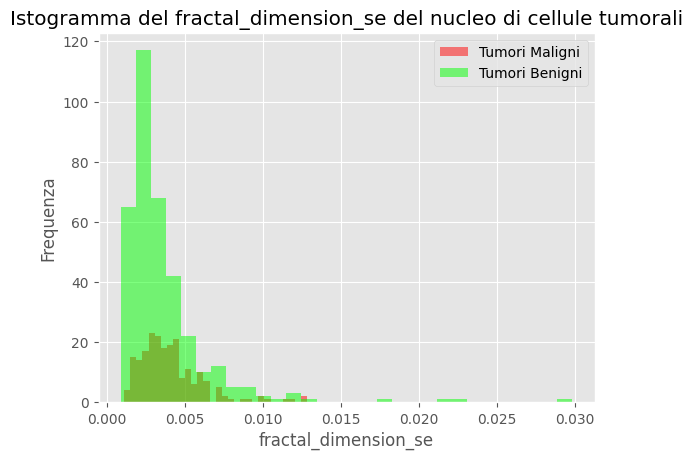

In [ ]:
for i in lista:
  m = plt.hist(data[data["diagnosis"] == 1][i], bins=30, fc=(1,0,0,0.5), label="Tumori Maligni")
  b = plt.hist(data[data["diagnosis"] == 0][i], bins=30, fc=(0,1,0,0.5), label="Tumori Benigni")
  plt.legend()
  plt.xlabel(f"{i}")
  plt.ylabel("Frequenza")
  plt.title("Istogramma del {} del nucleo di cellule tumorali".format(i))
  plt.show()
  frequent_malignant_radius_mean = m[0].max()

Iniziamo studiando la distribuzione delle variabili nel modo più semplice: l'istogramma ci permette di visualizzare quante volte ogni valore appare nel dataset (frequenza).

Possiamo andare ad osservare in particolare alcuni parametri: nonostante ci sia leggera sovrapposizione, si nota che la maggior parte delle cellule di tumori benigni hanno un raggio (e perciò un'area) minore rispetto a quelle dei tumori maligni. Stesso discorso vale per la concavità.



Le distribuzioni di raggio e area riguardanti i tumori benigni sono approssimabili ad una normale.

Dai grafici, possiamo notare che il raggio e la compatezza medie dei nuclei di cellule appartenenti a tumori maligni sono tendenzialmente maggiori di quelle nei tumori benigni.

### **Curve**

Andiamo a disegnare le curve per i parametri che vogliamo approfondire:

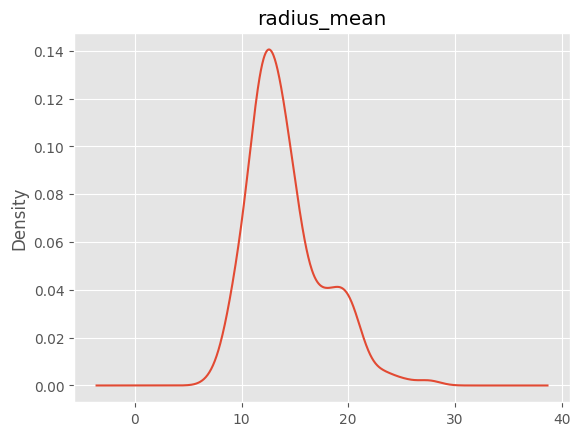

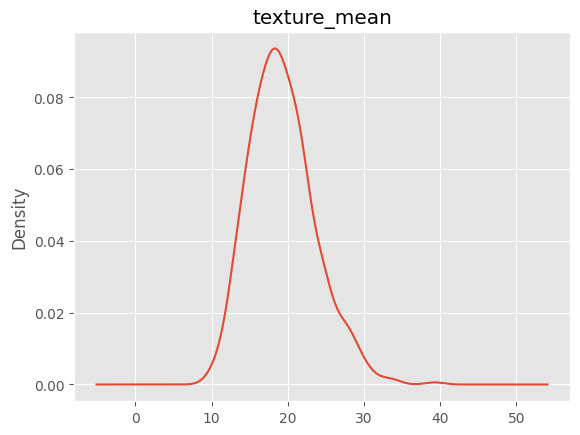

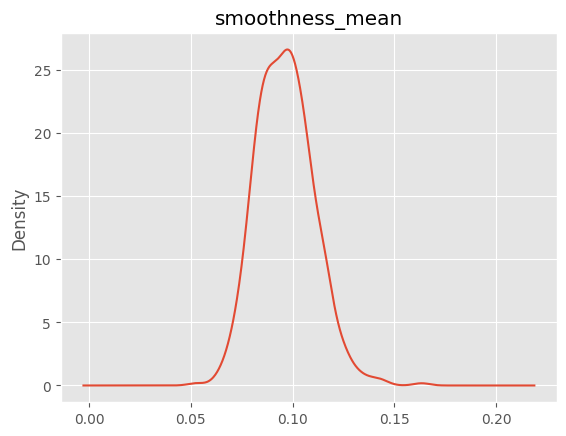

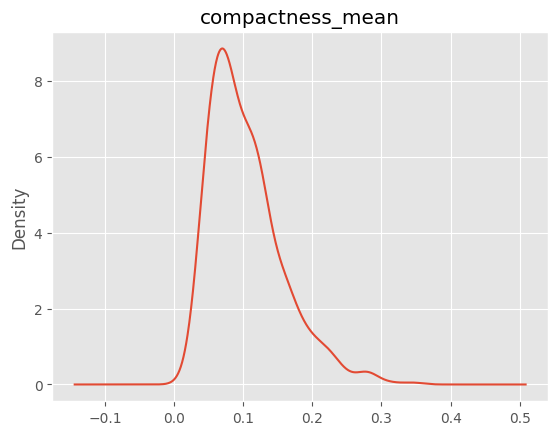

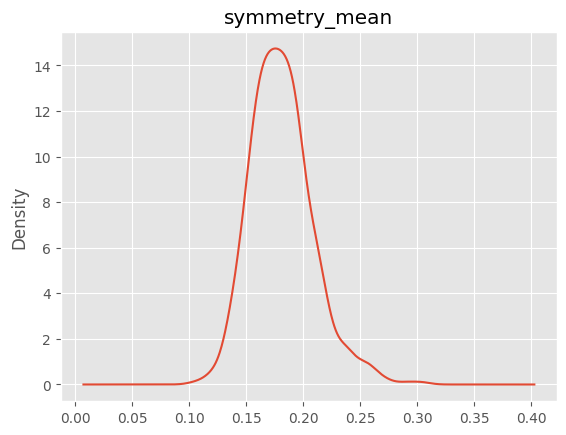

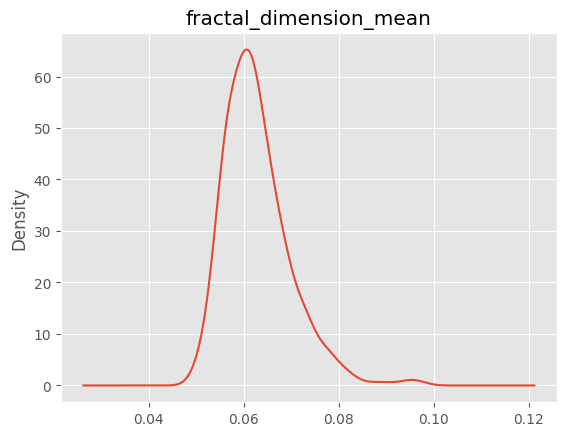

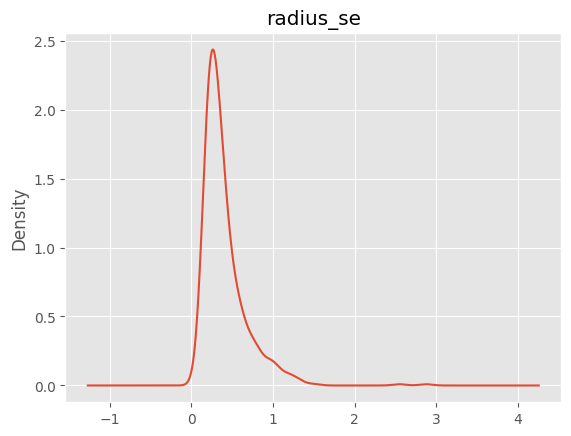

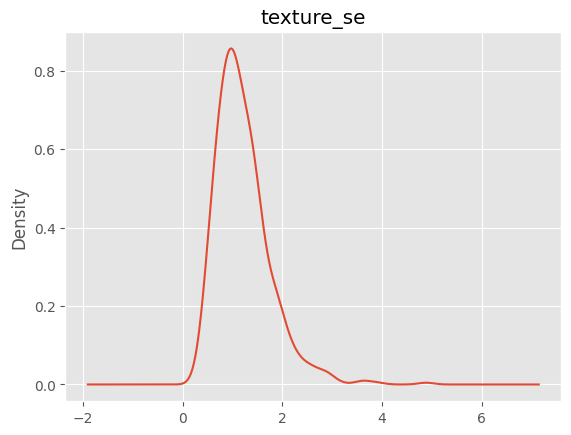

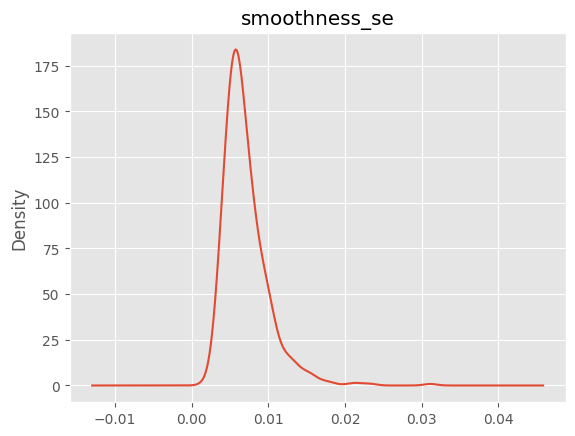

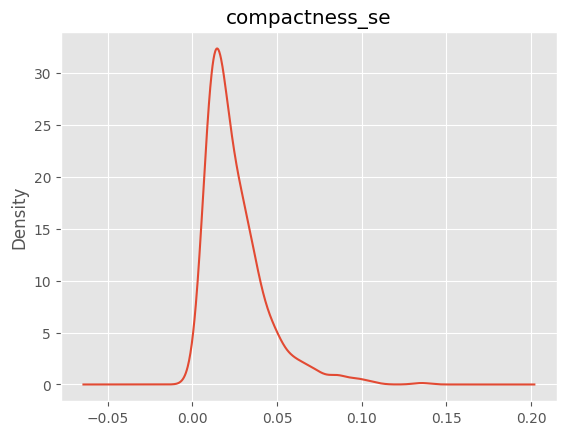

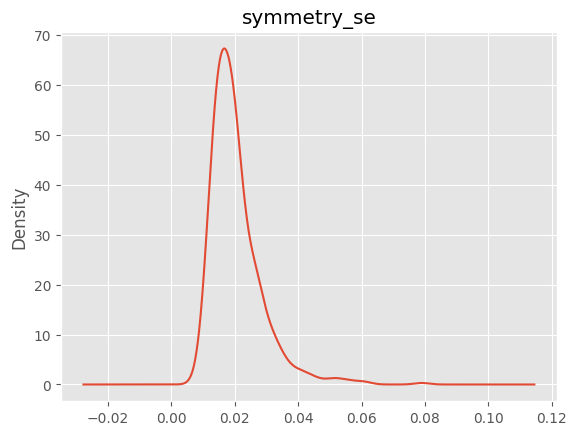

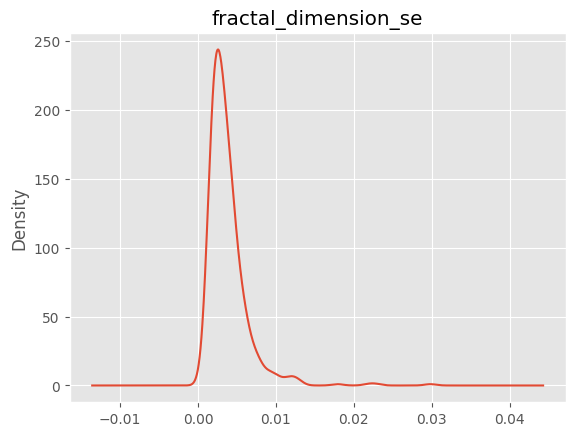

In [ ]:
for i in lista:
  data[i].plot.kde(title = i)
  plt.show()

Possiamo osservare nella curva del raggio medio una curtosi positiva e un'asimmetria positiva.

(curtosi = allontanamento dalla normalità distributiva, rispetto alla quale si verifica un maggiore appiattimento o un maggiore allungamento. La sua misura più nota è l'indice di Pearson)

Chiaramente ciò è dovuto al fatto che abbiamo meno dati riguardanti i tumori maligni (vedi istogramma 1). Il secondo picco nel grafico del raggio è dovuto al fatto che sto osservando contemporaneamente i dati di tumori benigni e maligni, non alla presenza di outliers. Possiamo vederlo meglio andando a separare le due curve:

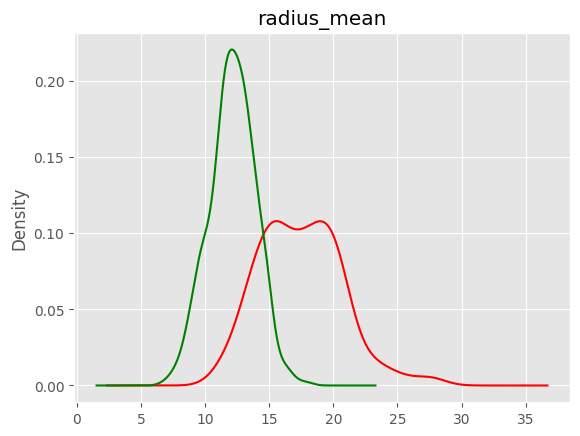

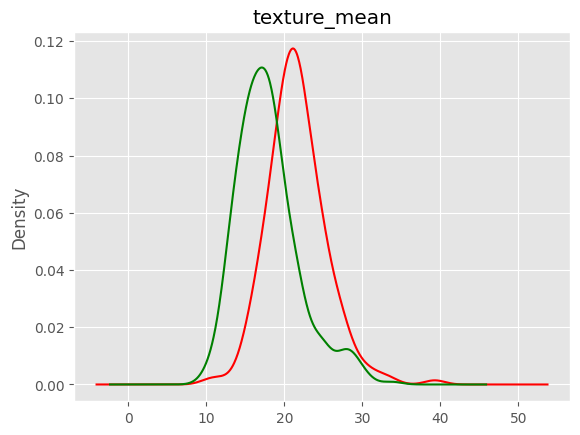

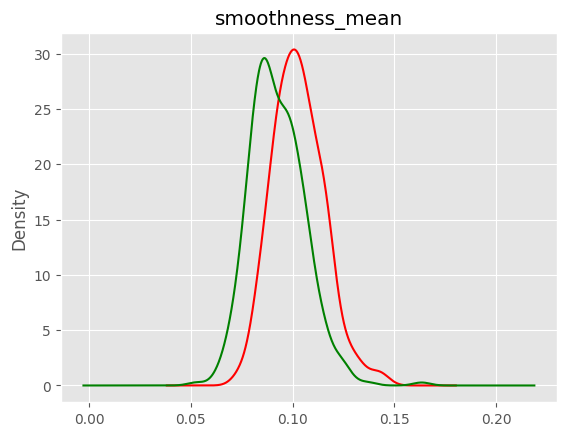

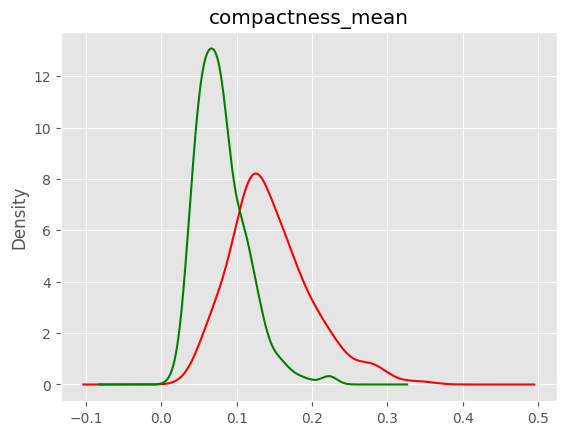

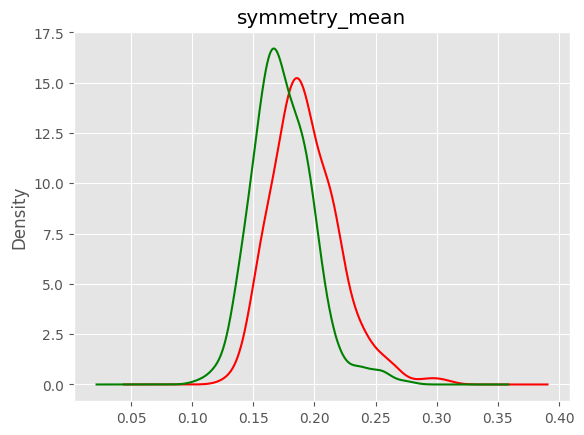

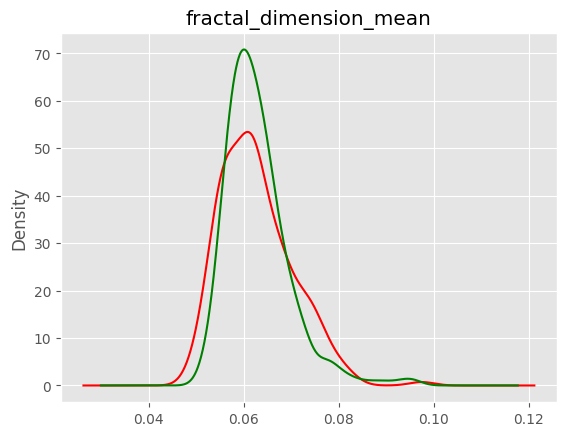

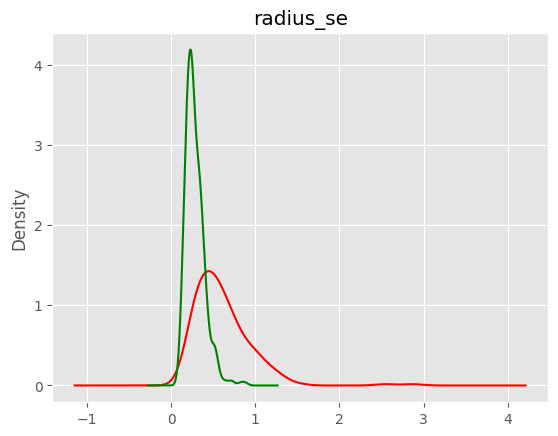

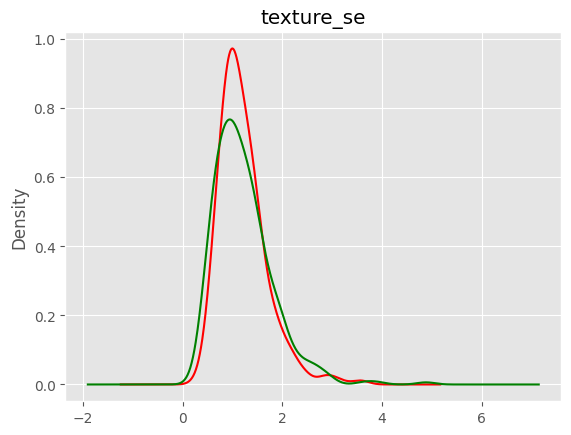

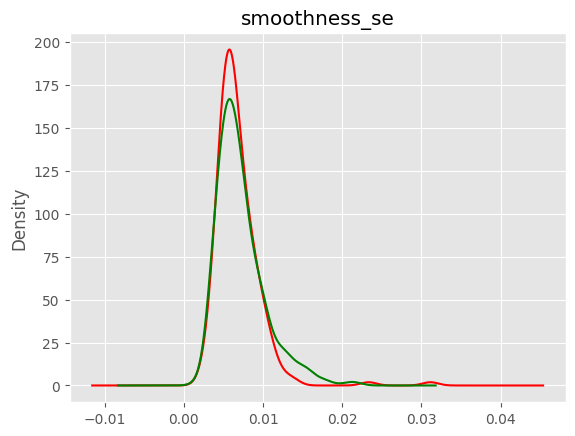

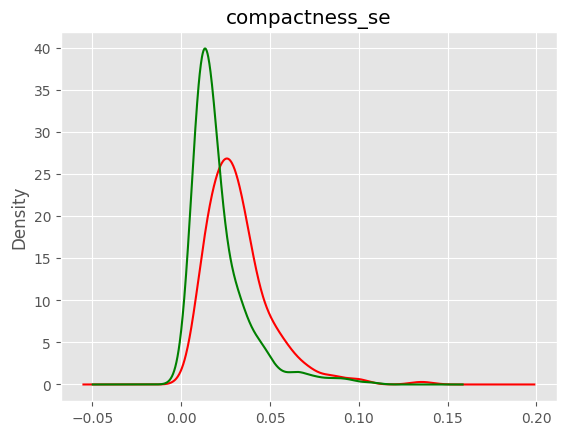

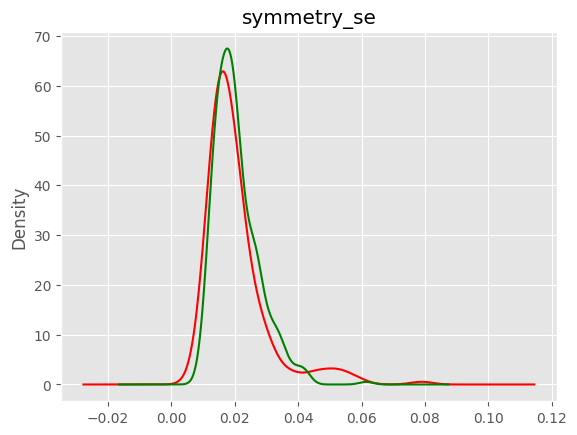

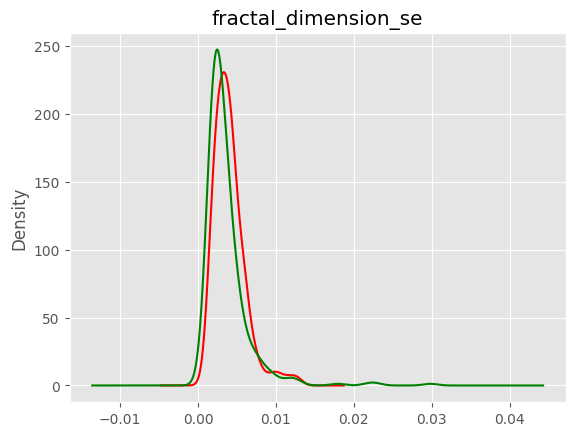

In [ ]:
for i in lista:
  data[i][data["diagnosis"] == 1].plot.kde(title = i, c = "r")
  data[i][data["diagnosis"] == 0].plot.kde(title = i, c = "g")
  plt.show()

### PCA

**Queste qui sotto sono le celle che si trovano alla fine del capitolo della colineaarità, va spiegato meglio il senso della PCA.**

avremo bisogno, per la PCA, di un y contenente i valori di diagnosis, mentre non devono essere presenti, tali valori, nell'originario dataset.

In [ ]:
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis=1)

In [ ]:
x.head()

radius_mean  texture_mean  perimeter_mean  area_mean  smoothness_mean  \
0        17.99         10.38          122.80     1001.0          0.11840   
1        20.57         17.77          132.90     1326.0          0.08474   
2        19.69         21.25          130.00     1203.0          0.10960   
3        11.42         20.38           77.58      386.1          0.14250   
4        20.29         14.34          135.10     1297.0          0.10030   

   compactness_mean  concavity_mean  concave points_mean  symmetry_mean  \
0           0.27760          0.3001              0.14710         0.2419   
1           0.07864          0.0869              0.07017         0.1812   
2           0.15990          0.1974              0.12790         0.2069   
3           0.28390          0.2414              0.10520         0.2597   
4           0.13280          0.1980              0.10430         0.1809   

   fractal_dimension_mean  radius_se  texture_se  perimeter_se  area_se  \
0                 0.07871     1.0950      0.9053         8.589   153.40   
1                 0.05667     0.5435      0.7339         3.398    74.08   
2                 0.05999     0.7456      0.7869         4.585    94.03   
3                 0.09744     0.4956      1.1560         3.445    27.23   
4                 0.05883     0.7572      0.7813         5.438    94.44   

   smoothness_se  compactness_se  concavity_se  concave points_se  \
0       0.006399         0.04904       0.05373            0.01587   
1       0.005225         0.01308       0.01860            0.01340   
2       0.006150         0.04006       0.03832            0.02058   
3       0.009110         0.07458       0.05661            0.01867   
4       0.011490         0.02461       0.05688            0.01885   

   symmetry_se  fractal_dimension_se  radius_worst  texture_worst  \
0      0.03003              0.006193         25.38          17.33   
1      0.01389              0.003532         24.99          23.41   
2      0.02250              0.004571         23.57          25.53   
3      0.05963              0.009208         14.91          26.50   
4      0.01756              0.005115         22.54          16.67   

   perimeter_worst  area_worst  smoothness_worst  compactness_worst  \
0           184.60      2019.0            0.1622             0.6656   
1           158.80      1956.0            0.1238             0.1866   
2           152.50      1709.0            0.1444             0.4245   
3            98.87       567.7            0.2098             0.8663   
4           152.20      1575.0            0.1374             0.2050   

   concavity_worst  concave points_worst  symmetry_worst  \
0           0.7119                0.2654          0.4601   
1           0.2416                0.1860          0.2750   
2           0.4504                0.2430          0.3613   
3           0.6869                0.2575          0.6638   
4           0.4000                0.1625          0.2364   

   fractal_dimension_worst  
0                  0.11890  
1                  0.08902  
2                  0.08758  
3                  0.17300  
4                  0.07678

In [ ]:
# la PCA ha bisogno della standardizzazione dei dati
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)


vogliamo prima valutare la significatività delle prime componenti principali

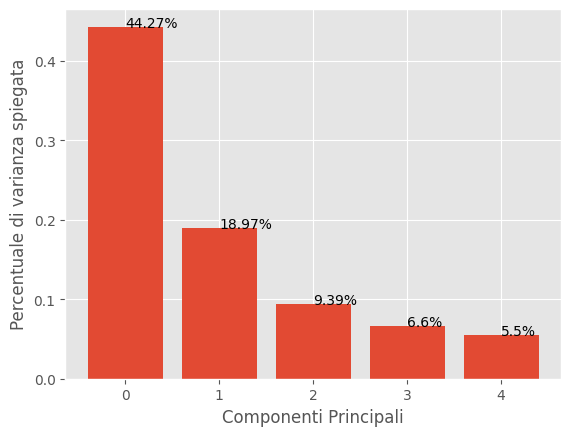

In [ ]:
pca = PCA(n_components=5) #numero di parametri da aggiungere dopo la riduzione della dimensionalità
pca.fit(x_scaled) #utilizzo il metodo fit per addestrare il modello di PCA sui dati x_scaled

# Calcolo dei valori di significatività delle componenti principali
variance_ratio = pca.explained_variance_ratio_

# Visualizzazione dei valori di significatività in un grafico a barre
plt.bar(range(len(variance_ratio)), variance_ratio) #funzione bar per creare il grafico a barre
plt.xlabel('Componenti Principali')
plt.ylabel('Percentuale di varianza spiegata')

# Aggiunta dell'etichetta con i valori di significatività nel grafico
for i, val in enumerate(variance_ratio):
    plt.text(i, val, str(round(val*100, 2)) + '%') #la funzione text utilizzata per aggiungere le etichette con i valori di significatività

plt.show()

Le prime 3 componenti principali spiegano da sole più del 85% della singificatività dei dati.
Possiamo quindi prendere queste tre prime componenti principali e andarle a graficare, ottenendo un grafico scatter plot in 3D.

In [ ]:
# Costruzione PCA
pca = PCA(n_components = 3)
pca.fit(x_scaled) #addestro il modello PCA sui dati standardizzati
X_reduced_pca = pca.transform(x_scaled) #trasforma i dati originali in un insieme di dati ridotti

pca_data = pd.DataFrame(X_reduced_pca,columns=["p1","p2","p3"]) #creiamo un nuovo dataframe con i dati ridotti e assegnamo le varie etichette alle colonne
pca_data["diagnosis"] = y

In [ ]:
hue = pca_data["diagnosis"]
data = [
    go.Scatter3d(
        x=pca_data.p1,
        y=pca_data.p2,
        z=pca_data.p3,
        mode='markers',
        marker=dict(
            size=4,
            color=hue,
            symbol="circle",
            line=dict(width=2)
        )
    )
]

layout = go.Layout(title="PCA",
                   scene=dict(
                       xaxis=dict(title="p1"),
                       yaxis=dict(title="p2"),
                       zaxis=dict(title="p3")
                   ),
                   hovermode="closest")

fig = go.Figure(data=data, layout=layout)

# aggiunta animazione per rotazione
fig.update_layout(scene=dict(camera=dict(up=dict(x=0, y=0, z=1),
                                         center=dict(x=0, y=0, z=0),
                                         eye=dict(x=2, y=2, z=0.1))),
                  updatemenus=[dict(type='buttons',
                                    showactive=False,
                                    buttons=[dict(label='Rotate',
                                                  method='animate',
                                                  args=[None,
                                                        dict(frame=dict(duration=50, redraw=True),
                                                             fromcurrent=True,
                                                             transition=dict(duration=0))
                                                       ]
                                                 )
                                            ]
                                   )
                             ])

pyo.iplot(fig)

possiamo vedere chiaramente nel grafico come si distinguino due cluster, con ancora più significatività data dalla terza componente principale. Possiamo comunque apprezzare una significativa divisione in cluster da uno scatter plot in 2D

In [ ]:
data=data_save
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis=1)

# la PCA ha bisogno della standardizzazione dei dati
scaler = StandardScaler()
x_scaled = scaler.fit_transform(x)

# Costruzione PCA
pca = PCA(n_components = 2)
pca.fit(x_scaled)
X_reduced_pca = pca.transform(x_scaled)

pca_data = pd.DataFrame(X_reduced_pca,columns=["p1","p2"])
pca_data["diagnosis"] = y
hue =pca_data["diagnosis"]
data = [go.Scatter(x = pca_data.p1,
                   y = pca_data.p2,
                   mode = 'markers',
                   marker=dict(
                           size=12,
                           color=hue,
                           symbol="pentagon",
                           line=dict(width=2)
                           ))]

layout = go.Layout(title="PCA",
                   xaxis=dict(title="p1"),
                   yaxis=dict(title="p2"),
                   hovermode="closest")
fig = go.Figure(data=data,layout=layout)
pyo.iplot(fig)

### **Outliers**

Osservando l'istogramma di distribuzione delle aree medie, ci accorgiamo della presenza di alcuni valori più rari nelle due distribuzioni. Questi valori possono essere dovuti ad errori o eventi rari e vengono chiamati "outlier".

Per calcolare gli outlier bisogna:
- calcolare il primo quartile (Q1)(25%);
- trovare l'IQR (Inter Quartile Range) = Q3 - Q1;
- calcolare Q1 - 1.5 IQR e Q3 + 1.5 IQR;
- ogni valore al di fuori di questo range è un outlier.

In [ ]:
data = data_save

In [ ]:
data_bening = data[data["diagnosis"] == 0]
data_bening.drop('diagnosis', inplace=True, axis=1)
list_column = data_bening.columns

In [ ]:
for element in list_column:
  print("\n" + element.upper())
  data_bening = data[data["diagnosis"] == 0]
  desc = data_bening[element].describe()
  Q1 = desc[4]
  Q3 = desc[6]
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  print("\nPer i tumori benigni, ogni valore fuori da questo range è un outlier: (", lower_bound ,",", upper_bound,")")
  data_bening[data_bening[element] < lower_bound][element]
  print("Outliers: ", data_bening[(data_bening[element] < lower_bound) | (data_bening[element] > upper_bound)][element].values)


RADIUS_MEAN

Per i tumori benigni, ogni valore fuori da questo range è un outlier: ( 7.645000000000001 , 16.805 )
Outliers:  [ 6.981 16.84  17.85 ]

TEXTURE_MEAN

Per i tumori benigni, ogni valore fuori da questo range è un outlier: ( 8.235 , 26.675000000000004 )
Outliers:  [27.08 33.81 27.85 28.21 28.23 30.72 29.29 28.2  26.99 28.14 29.97 28.06
 29.43 28.92 27.61 27.88 27.15 29.37]

PERIMETER_MEAN

Per i tumori benigni, ogni valore fuori da questo range è un outlier: ( 48.02500000000002 , 108.94499999999998 )
Outliers:  [ 43.79 114.6   47.98  47.92]

AREA_MEAN

Per i tumori benigni, ogni valore fuori da questo range è un outlier: ( 118.84999999999997 , 810.45 )
Outliers:  [880.2 838.1 992.1 819.8]

SMOOTHNESS_MEAN

Per i tumori benigni, ogni valore fuori da questo range è un outlier: ( 0.05659999999999999 , 0.12716 )
Outliers:  [0.1291  0.1634  0.1371  0.05263]

COMPACTNESS_MEAN

Per i tumori benigni, ogni valore fuori da questo range è un outlier: ( -0.00727499999999999 , 0.160445 )

In [ ]:
data_malignant = data[data["diagnosis"] == 1]
data_malignant.drop('diagnosis', inplace=True, axis=1)
data_malignant.head()
list_column = data_malignant.columns

In [ ]:
for element in list_column:
  print("\n" + element.upper())
  data_malignat = data[data["diagnosis"] == 1]
  desc = data_malignant[element].describe()
  Q1 = desc[4]
  Q3 = desc[6]
  IQR = Q3-Q1
  lower_bound = Q1 - 1.5*IQR
  upper_bound = Q3 + 1.5*IQR
  print("\nPer i tumori maligni, ogni valore fuori da questo range è un outlier: (", lower_bound ,",", upper_bound,")")
  data_malignant[data_malignant[element] < lower_bound][element]
  print("Outliers: ", data_malignant[(data_malignant[element] < lower_bound) | (data_malignant[element] > upper_bound)][element].values)


RADIUS_MEAN

Per i tumori maligni, ogni valore fuori da questo range è un outlier: ( 8.302499999999998 , 26.3625 )
Outliers:  [27.22 28.11 27.42]

TEXTURE_MEAN

Per i tumori maligni, ogni valore fuori da questo range è un outlier: ( 12.67125 , 30.42125 )
Outliers:  [10.38 11.89 32.47 39.28 33.56 31.12 30.62]

PERIMETER_MEAN

Per i tumori maligni, ogni valore fuori da questo range è un outlier: ( 51.974999999999994 , 176.69500000000002 )
Outliers:  [182.1 188.5 186.9]

AREA_MEAN

Per i tumori maligni, ogni valore fuori da questo range è un outlier: ( -42.375000000000114 , 1951.4250000000002 )
Outliers:  [2250. 2499. 2010. 2501.]

SMOOTHNESS_MEAN

Per i tumori maligni, ogni valore fuori da questo range è un outlier: ( 0.06863749999999999 , 0.1362975 )
Outliers:  [0.1425 0.1398 0.1447]

COMPACTNESS_MEAN

Per i tumori maligni, ogni valore fuori da questo range è un outlier: ( 0.015400000000000011 , 0.2666 )
Outliers:  [0.2776 0.2839 0.3454 0.2768 0.2867 0.2832 0.3114 0.277 ]

CONCAVITY_ME

Rilevazione degli outliers utilizzando DBSCAN sulla PCA

In [ ]:

from sklearn.cluster import DBSCAN

# Apply DBSCAN to the PCA data
dbscan = DBSCAN(eps=0.5, min_samples=5)
dbscan.fit(X_reduced_pca)

# Get the outliers identified by DBSCAN
outliers = pca_data[dbscan.labels_ == -1]

# Visualize the PCA with outliers highlighted
data = [go.Scatter(x = pca_data.p1,
                   y = pca_data.p2,
                   mode = 'markers',
                   marker=dict(
                           size=12,
                           color=hue,
                           symbol="pentagon",
                           line=dict(width=2)
                           )),
        go.Scatter(x = outliers.p1,
                   y = outliers.p2,
                   mode = 'markers',
                   marker=dict(
                           size=3,
                           color='red',
                           symbol="circle",
                           line=dict(width=2)
                           ))]

layout = go.Layout(title="PCA with Outliers Detected by DBSCAN",
                   xaxis=dict(title="p1"),
                   yaxis=dict(title="p2"),
                   hovermode="closest")

fig = go.Figure(data=data,layout=layout)
pyo.iplot(fig)


### **Box Plot**

È un altro modo di visualizzare gli outlier.

In [ ]:
data = data_final

In [ ]:
data_bening = data[data["diagnosis"] == 0]
data_bening.drop('diagnosis', inplace=True, axis=1)
list_column = data_bening.columns

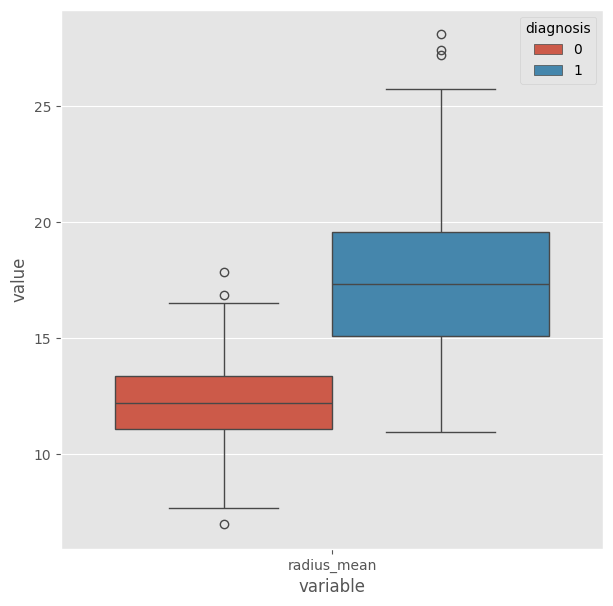

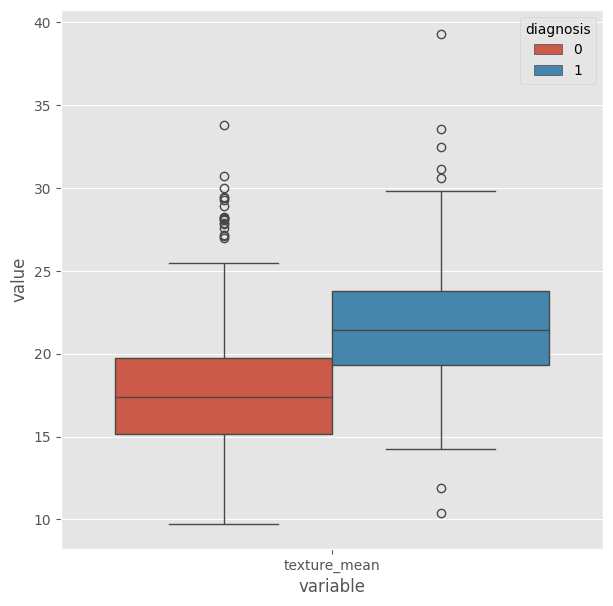

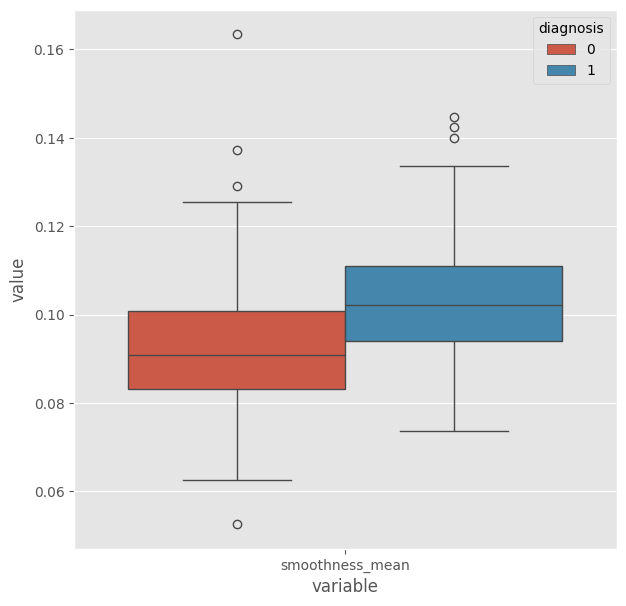

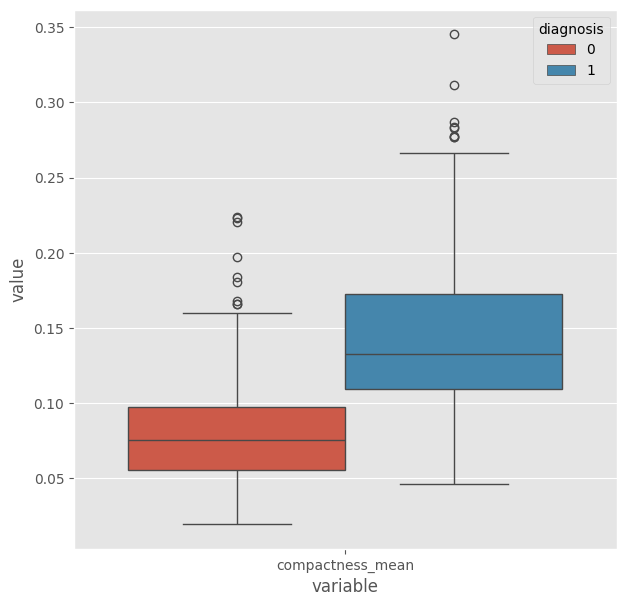

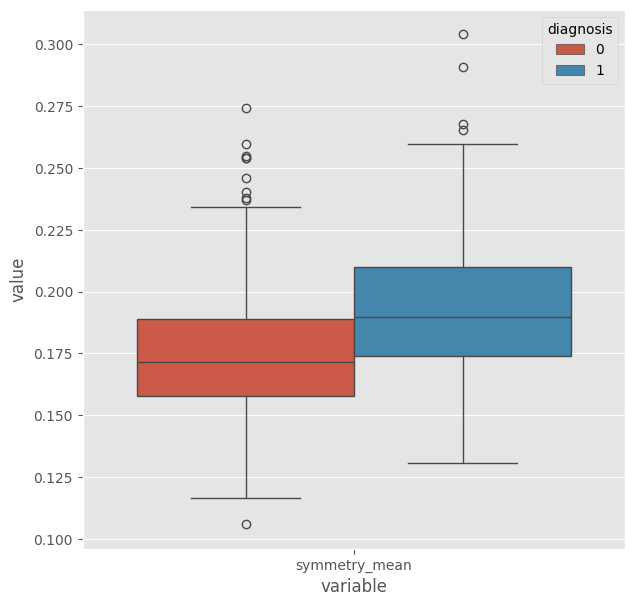

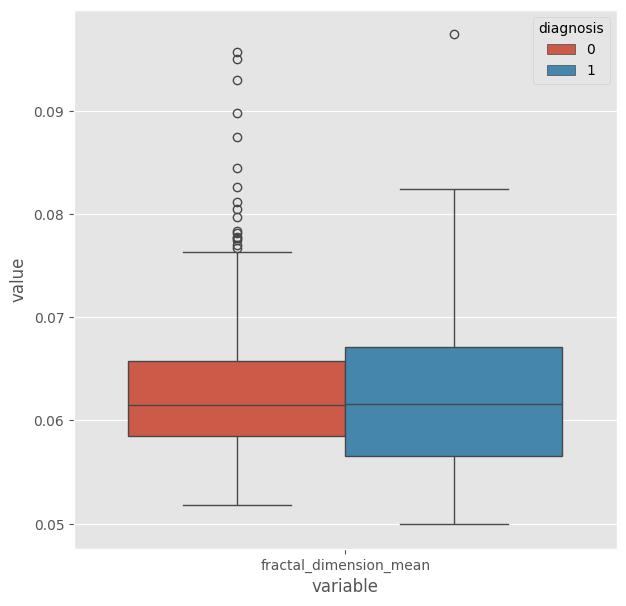

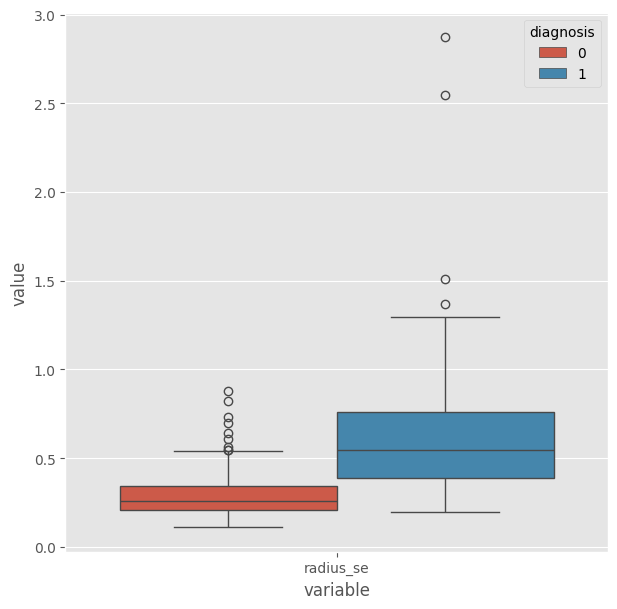

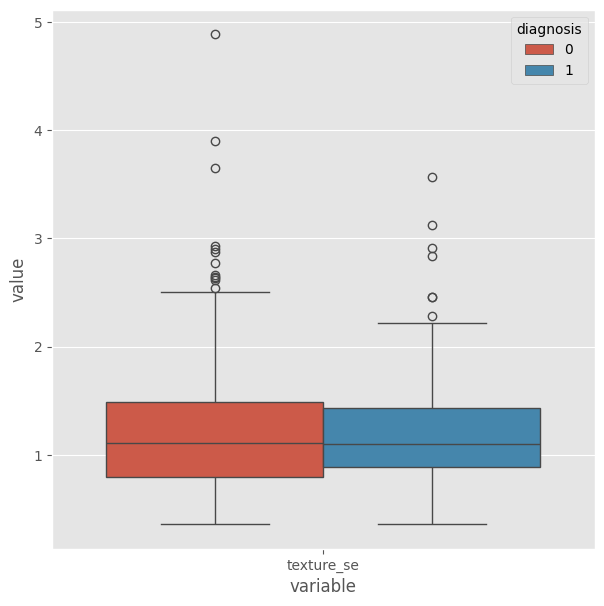

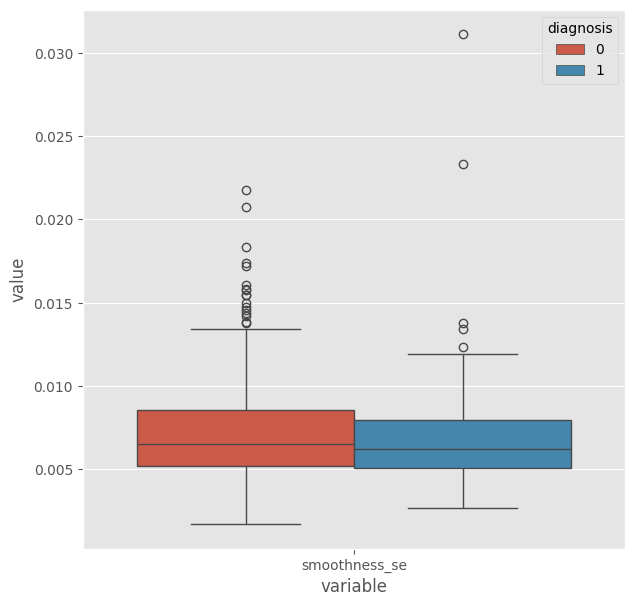

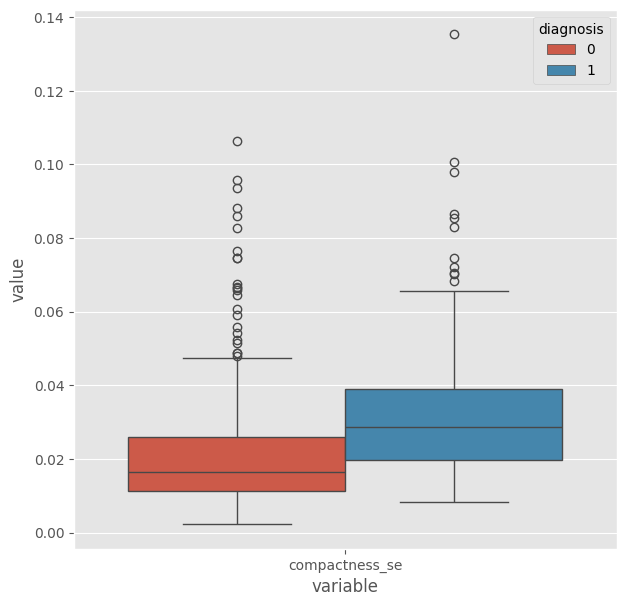

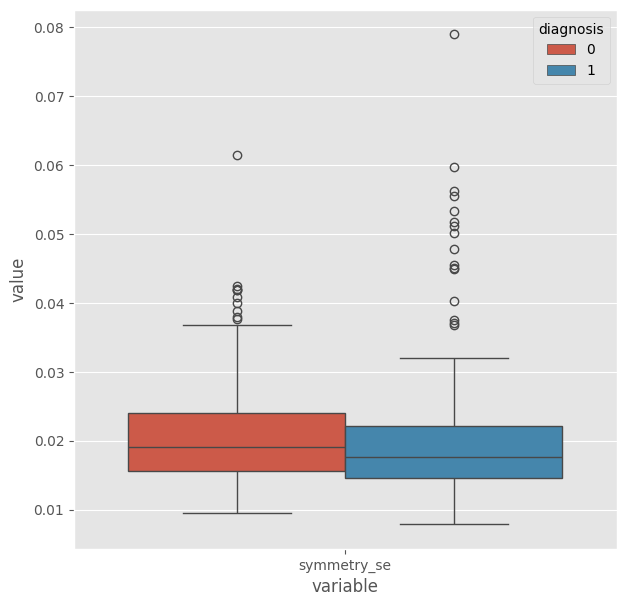

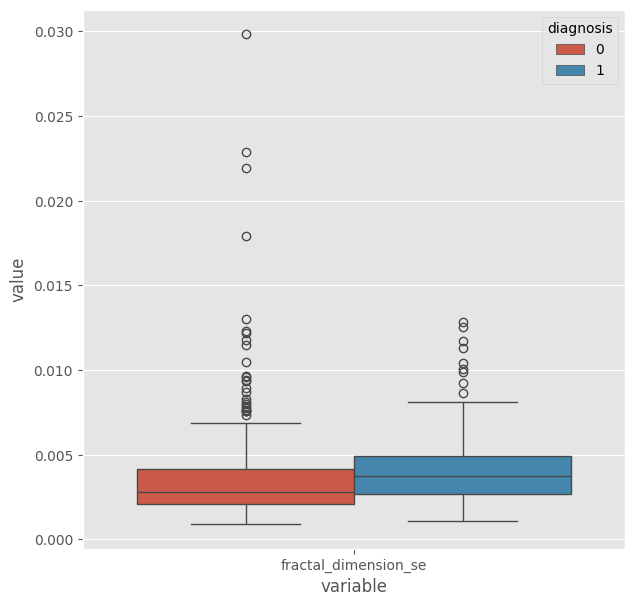

In [ ]:
for element in list_column:
  melted_data = pd.melt(data,id_vars = "diagnosis",value_vars = element)
  plt.figure(figsize = (7,7))
  sns.boxplot(x = "variable" , y = "value", hue="diagnosis",data = melted_data)
  plt.show()

### **Violin plot**

I grafici a violino (violin plot) prendono spunto dai grafici a scatola con i baffi (boxplot) riportando per una distribuzione univariata, al posto delle classiche scatole, il profilo di densità dei valori osservati sotto forma di kernel density plot (stima di densità).

La forma tipica dei grafici, che dà loro il nome, deriva dal fatto che il kernel density plot dei dati è riportato simmetricamente da entrambi i lati della distribuzione.

In [ ]:
y = data["diagnosis"]
x = data.drop(["diagnosis"],axis=1)

([0, 1, 2, 3, 4, 5, 6, 7, 8, 9, 10, 11],
 [Text(0, 0, 'radius_mean'),
  Text(1, 0, 'texture_mean'),
  Text(2, 0, 'smoothness_mean'),
  Text(3, 0, 'compactness_mean'),
  Text(4, 0, 'symmetry_mean'),
  Text(5, 0, 'fractal_dimension_mean'),
  Text(6, 0, 'radius_se'),
  Text(7, 0, 'texture_se'),
  Text(8, 0, 'smoothness_se'),
  Text(9, 0, 'compactness_se'),
  Text(10, 0, 'symmetry_se'),
  Text(11, 0, 'fractal_dimension_se')])

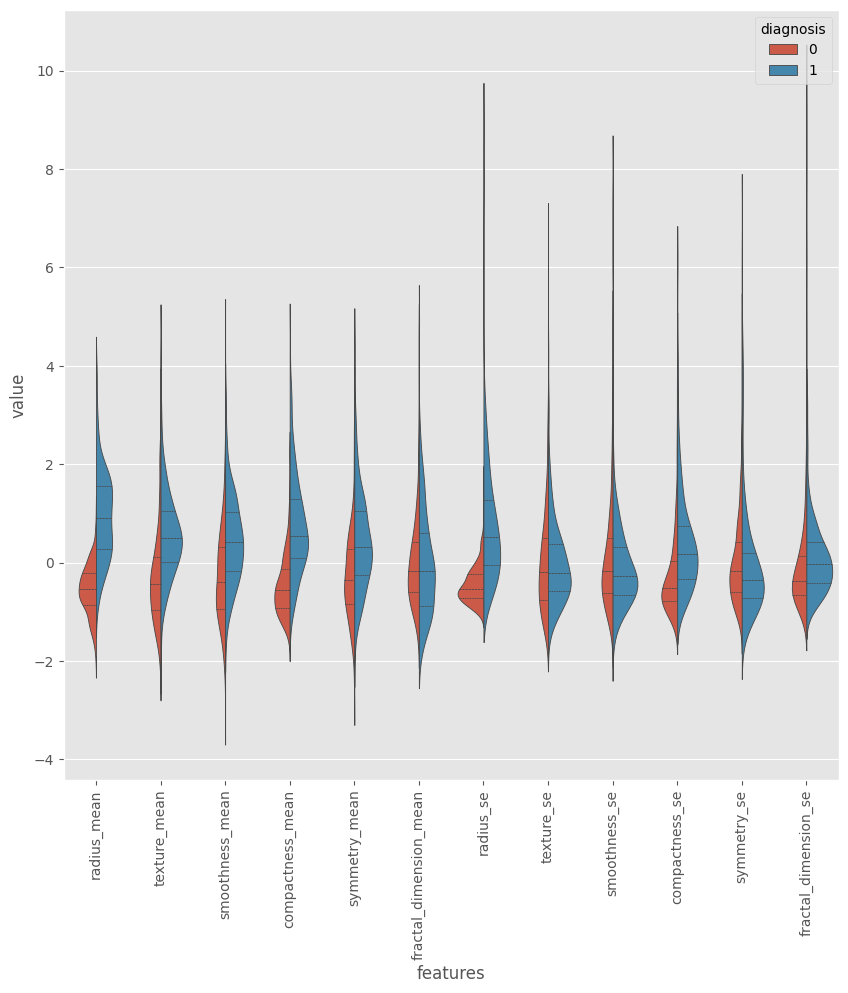

In [ ]:
data_dia = y
data = x
data_n_2 = (data - data.mean()) / (data.std())              # standardization
data = pd.concat([y, data_n_2], axis=1)

data = pd.melt(data,id_vars="diagnosis",
                    var_name="features",
                    value_name='value')
plt.figure(figsize=(10,10))
sns.violinplot(x="features", y="value", hue="diagnosis", data=data, split=True, inner="quart")
plt.xticks(rotation=90)

### **Dimensione dell'effetto di Cohen**

La dimensione dell'effetto di Cohen è una misura statistica che indica la differenza tra le medie di due gruppi divisa per la deviazione standard comune dei due gruppi. La sua interpretazione pratica è la seguente: una dimensione dell'effetto di Cohen di 0.2 indica una piccola differenza tra i due gruppi, 0.5 indica una differenza media e 0.8 indica una grande differenza.

È una delle statistiche utilizzate per riassumere un set di osservazioni e comunicare, quindi, la maggior quantità di informazioni nel modo più semplice possibile.

Descrive le dimensioni di un effetto, cioè la forza della relazione tra due variabili.

Compariamo la dimensione dell'effetto tra la media del raggio in tumori benigni e maligni.

In [ ]:
data = data_final

In [ ]:
# Dividi il dataframe in due gruppi sulla base della colonna diagnosis
gruppo_0 = data.loc[data['diagnosis'] == 0]
gruppo_1 = data.loc[data['diagnosis'] == 1]

# Seleziona le colonne del dataframe che non contengono valori dicotomici
colonne = [col for col in data.columns if col != 'diagnosis']

# Calcola la dimensione dell'effetto di Cohen per ogni colonna del dataframe
for col in colonne:
    diff_media = gruppo_0[col].mean() - gruppo_1[col].mean()
    std_com = (gruppo_0[col].std() + gruppo_1[col].std()) / 2
    d = abs(diff_media / std_com)
    print("Dimensione dell'effetto di Cohen per la feature", col, ":", d)


Dimensione dell'effetto di Cohen per la feature radius_mean : 2.133142654547272
Dimensione dell'effetto di Cohen per la feature texture_mean : 0.9492826278607378
Dimensione dell'effetto di Cohen per la feature smoothness_mean : 0.7999323240398258
Dimensione dell'effetto di Cohen per la feature compactness_mean : 1.4840449872397312
Dimensione dell'effetto di Cohen per la feature symmetry_mean : 0.7140059602231225
Dimensione dell'effetto di Cohen per la feature fractal_dimension_mean : 0.026158102577377294
Dimensione dell'effetto di Cohen per la feature radius_se : 1.4204299748345488
Dimensione dell'effetto di Cohen per la feature texture_se : 0.017653602865554306
Dimensione dell'effetto di Cohen per la feature smoothness_se : 0.13974285183443033
Dimensione dell'effetto di Cohen per la feature compactness_se : 0.6242558412243518
Dimensione dell'effetto di Cohen per la feature symmetry_se : 0.01305784333545201
Dimensione dell'effetto di Cohen per la feature fractal_dimension_se : 0.171236

## **7. Algoritmi di Machine Learning**

Applichiamo ora vari modelli di machine learining per la classificazione binaria dei campioni in tumori Benigni e Maligni.

### **7.0 Preparazione dati**

il dataset contiene le 569 istanze di lesioni mammarie descritte da 30 caratteristiche quantitative. Di queste ne abbiamo selezionate 12 per l'analisi. La features diagnosis rappresenta l'etichetta di classe (M per maligno e B per benigno).

Il codice carica il dataset utilizzando pandas, converte le etichette di classe in valori numerici, divide i dati in training e test set, normalizza i dati e addestra diversi modelli di machine learning per predire la classe (B o M).

Infine, per ongi modello viene utilizzato per prevedere le etichette delle classi per i dati di test e viene calcolata l'accuratezza.

In [ ]:
data = data_final

In [ ]:
X = data.drop(['diagnosis'],axis=1)
y = data['diagnosis']

In [ ]:
# Dividi i dati in training e test set
X_train, X_test,y_train, y_test=train_test_split(X,y,test_size=0.2,random_state=42)

In [ ]:
print(f"Train set:\n{y_train.value_counts()}")


Train set:
0    286
1    169
Name: diagnosis, dtype: int64


In [ ]:
print(f"Test set:\n{y_test.value_counts()}")

Test set:
0    71
1    43
Name: diagnosis, dtype: int64


In [ ]:
# Applica la standardizzazione ai dati (Feature scaling)
scaler = StandardScaler()
X_train_scaled = scaler.fit_transform(X_train)
X_test_scaled = scaler.transform(X_test)

### **7.1 KNN** (K-nearest neighbors)

Applichiamo grid search di scikitlearn per trovare i migliori iperparametri per un modello di KNN:

In [ ]:
# Crea il modello di KNN
knn = KNeighborsClassifier()

# Definisci una griglia di valori per i parametri da testare
param_grid = {'n_neighbors': [3, 5, 7, 9, 11], 'weights': ['uniform', 'distance'], 'algorithm': ['auto', 'ball_tree', 'kd_tree', 'brute']}

# Crea un oggetto GridSearchCV per la ricerca dei migliori iperparametri
grid_search = GridSearchCV(knn, param_grid, cv=5)

# Esegui la ricerca dei migliori iperparametri sui dati di addestramento
grid_search.fit(X_train_scaled, y_train)

# Stampa i migliori iperparametri trovati
print("Iperparametri ottimali:\n", grid_search.best_params_)

Iperparametri ottimali:
 {'algorithm': 'auto', 'n_neighbors': 3, 'weights': 'uniform'}


In questo esempio, viene creato un modello di KNN utilizzando la classe KNeighborsClassifier della libreria scikit-learn. Viene poi definita una griglia di valori per i parametri da testare tramite il dizionario param_grid. Il parametro cv nel GridSearchCV indica il numero di fold per la cross-validation. Infine, viene eseguita la ricerca dei migliori iperparametri tramite la funzione fit dell'oggetto GridSearchCV, e i risultati vengono stampati a schermo utilizzando best_params_.

<Axes: >

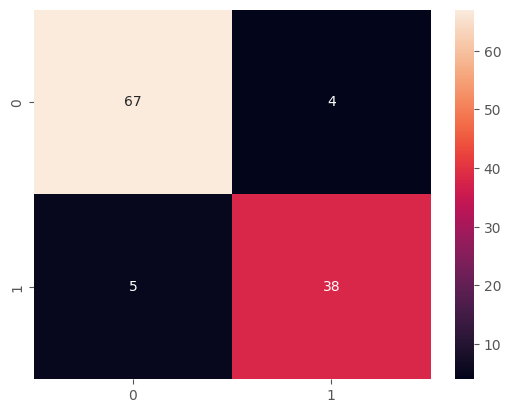

In [ ]:
# Crea il modello di KNN con i migliori iperparametri trovati
knn = KNeighborsClassifier(n_neighbors=3, weights='uniform', algorithm='auto')

# Addestramento del modello
model4 = knn.fit(X_train_scaled, y_train)

# Previsione delle etichette delle classi per i dati di test
prediction4 = model4.predict(X_test_scaled)

cm4 = confusion_matrix(y_test, prediction4)
sns.heatmap(cm4,annot=True)

In questo esempio, il modello di KNN viene creato utilizzando i migliori iperparametri trovati (n_neighbors=3, weights='uniform', algorithm='auto'). Successivamente, il modello viene addestrato sui dati di addestramento tramite il metodo fit, e infine vengono fatte le predizioni sul test set tramite il metodo predict.

In [ ]:
TP=cm4[0][0]
TN=cm4[1][1]
FN=cm4[1][0]
FP=cm4[0][1]
acc4 = (TP+TN)/(TP+TN+FN+FP)
print('Testing Accuracy:',acc4)

Testing Accuracy: 0.9210526315789473


In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction4)) #prediction?

              precision    recall  f1-score   support

           0       0.93      0.94      0.94        71
           1       0.90      0.88      0.89        43

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.92       114
weighted avg       0.92      0.92      0.92       114



### **7.2 SVM** (Support Vector Machine)

Applichiamo grid search di scikitlearn per trovare i migliori iperparametri per un modello di SVM:

In [ ]:
# Definisci i possibili valori degli iperparametri da testare
param_grid = {'C': [0.1, 1, 10, 100],
              'gamma': [0.1, 1, 10, 100],
              'kernel': ['linear', 'rbf', 'poly']}

# Crea un oggetto GridSearchCV per la ricerca degli iperparametri
grid_search = GridSearchCV(SVC(), param_grid, cv=5)

# Addestra il modello sul train set
grid_search.fit(X_train_scaled, y_train)

# Stampa i migliori iperparametri trovati
print("Iperparametri ottimali:\n", grid_search.best_params_)

Iperparametri ottimali:
 {'C': 1, 'gamma': 0.1, 'kernel': 'rbf'}


In questo esempio, la griglia degli iperparametri da testare è definita dalla variabile param_grid, che include una lista di possibili valori per i tre iperparametri del modello SVM (C, gamma, e kernel). Viene quindi creato un oggetto GridSearchCV che utilizza un modello SVM, la griglia degli iperparametri e la tecnica di cross-validation con 5 fold (cv=5). Il modello viene addestrato sui dati di addestramento tramite il metodo fit dell'oggetto GridSearchCV, e infine vengono stampati i migliori iperparametri trovati tramite l'attributo best_params_.

<Axes: >

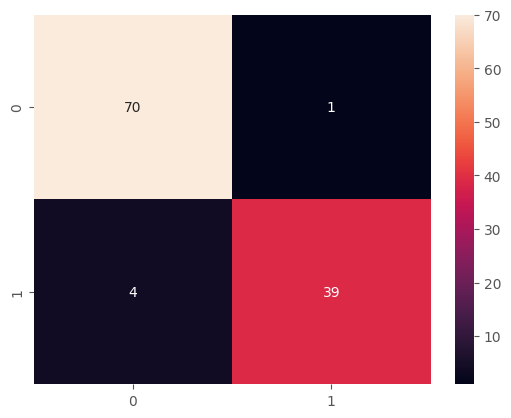

In [ ]:
# Crea il modello di SVM con i migliori iperparametri
svm = SVC(C=1, gamma=0.1, kernel='rbf')

# Addestrare il modello utilizzando il set di addestramento
model5 = svm.fit(X_train_scaled, y_train)

# Valutare le prestazioni del modello utilizzando il set di test
prediction5 = model5.predict(X_test_scaled)

cm5 = confusion_matrix(y_test, prediction5)
sns.heatmap(cm5,annot=True)

In [ ]:
TP=cm5[0][0]
TN=cm5[1][1]
FN=cm5[1][0]
FP=cm5[0][1]
acc5 = (TP+TN)/(TP+TN+FN+FP)
print('Testing Accuracy:',acc5)

Testing Accuracy: 0.956140350877193


In [ ]:
# Stampa la tabella di valutazione
print(classification_report(y_test, prediction5))

              precision    recall  f1-score   support

           0       0.95      0.99      0.97        71
           1       0.97      0.91      0.94        43

    accuracy                           0.96       114
   macro avg       0.96      0.95      0.95       114
weighted avg       0.96      0.96      0.96       114



In questo codice, viene creato un oggetto SVC con i migliori iperparametri (C=1, gamma=0.1, e kernel='rbf'). Il modello viene quindi addestrato sui dati di addestramento tramite il metodo fit, e infine vengono fatte le predizioni sul test set e calcolata l'accuratezza del modello tramite il metodo score.

In questo esempio, l'algoritmo SVM utilizza un kernel lineare, che è uno dei kernel più semplici e adatti per dataset di dimensioni medio-piccole come quello del Wisconsin Breast Cancer. Inoltre, è stata utilizzata la cross-validation per suddividere il dataset in set di addestramento e set di test. Infine, le metriche di valutazione dell'accuratezza, della precisione, del richiamo e dell'F1-score sono state utilizzate per valutare le prestazioni del modello SVM.

**Aggiornamento**
Questo codice carica il dataset del cancro al seno dal modulo sklearn.datasets, suddivide il dataset in set di addestramento e di test, normalizza gli attributi utilizzando la classe StandardScaler del modulo sklearn.preprocessing, crea un'istanza di svm.SVC con un kernel lineare e costante di regolarizzazione pari a 1, addestra il modello utilizzando il set di addestramento, effettua le predizioni sul set di test e calcola le prestazioni del modello utilizzando le metriche di accuratezza, precisione, richiamo e F1-score dal modulo sklearn.metrics.

### **7.3 Modello Logit (o Regressione Logistica)**

È un modello di regressione non lineare utilizzato quando la variabile dipendente è di tipo dicotomico. L'obiettivo del modello è di stabilire la probabilità con cui un'osservazione può generare uno o l'altro valore della variabile dipendente; può inoltre essere utilizzato per classificare le osservazioni, in base alla caratteristiche di queste, in due categorie.

Per eseguire una grid search per trovare i migliori iperparametri per la regressione logistica, devi prima definire una griglia di valori per ogni iperparametro che vuoi testare. Ecco i parametri che solitamente vengono messi in gioco per una regressione logistica:

penalty: specifica la norma utilizzata nella regolarizzazione. Puoi testare i valori "l1" e "l2".
C: il parametro di regolarizzazione inversa, che controlla la forza della regolarizzazione. Puoi testare i valori in un range di interesse, ad esempio [0.1, 1, 10].
solver: specifica l'algoritmo di ottimizzazione utilizzato per risolvere il problema di regressione logistica. Puoi testare i valori "lbfgs", "liblinear", "newton-cg", "sag" e "saga".
max_iter: il numero massimo di iterazioni consentite per il solutore per convergere. Puoi testare i valori in un range di interesse, ad esempio [100, 500, 1000].
Una volta definiti questi iperparametri e i valori da testare per ciascuno di essi, è possibile eseguire una grid search per trovare i parametri ottimali per la regressione logistica. Questo può essere fatto ad esempio utilizzando la classe GridSearchCV di scikit-learn.

In [ ]:
# definire i parametri da esplorare nella grid search
params = {'penalty': ['l1', 'l2'], 'C': [0.1, 1, 10], 'tol': [1e-3, 1e-4],
          'solver': ['lbfgs', 'liblinear', 'saga']}

# creare un'istanza del modello di regressione logistica
logreg=LogisticRegression(max_iter = 1000)

# creare un'istanza di GridSearchCV con il modello e i parametri
grid_search = GridSearchCV(logreg, params, cv=5)

# eseguire la grid search sul set di dati di addestramento
grid_search.fit(X_train_scaled, y_train)

# stampare i parametri ottimali e lo score di validazione incrociata
print("I parametri ottimali sono:", grid_search.best_params_)
print("Lo score di validazione incrociata è:", grid_search.best_score_)

I parametri ottimali sono: {'C': 0.1, 'penalty': 'l2', 'solver': 'liblinear', 'tol': 0.001}
Lo score di validazione incrociata è: 0.9296703296703297


Questo codice esegue una grid search con cross-validation a 5-fold per la regressione logistica utilizzando la griglia di iperparametri specificata. Alla fine, viene stampato il set di parametri ottimali trovati dalla grid search.

<Axes: >

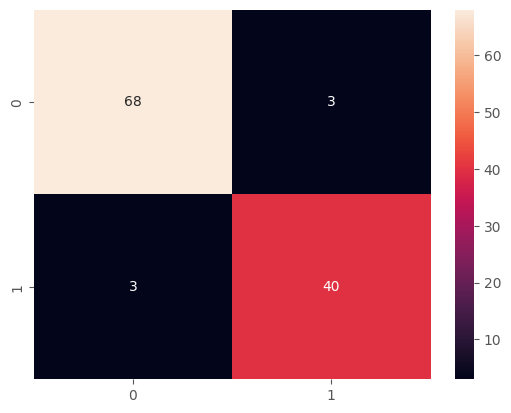

In [ ]:
# istanzia un nuovo oggetto di LogisticRegression con i parametri ottimali
logreg = LogisticRegression(penalty='l2', C=10, solver='lbfgs', tol=0.001)

# addestra il modello sul set di addestramento
model1 = logreg.fit(X_train_scaled,y_train)
prediction1 = model1.predict(X_test_scaled)

from sklearn.metrics import confusion_matrix

cm1 = confusion_matrix(y_test,prediction1)
sns.heatmap(cm1,annot=True)

In [ ]:
TP=cm1[0][0]
TN=cm1[1][1]
FN=cm1[1][0]
FP=cm1[0][1]
acc1 = (TP+TN)/(TP+TN+FN+FP)
print('Testing Accuracy:',acc1)

Testing Accuracy: 0.9473684210526315


L'accuratezza è una misura delle prestazioni del modello e indica la percentuale di previsioni corrette rispetto al totale delle previsioni. In questo caso, l'accuratezza del modello è del 94.73%, il che significa che il modello ha previsto correttamente il 94.73% dei casi nel set di test.

Questo valore di accuratezza è positivo, ma potrebbe essere utile anche valutare altre metriche come la precisione, il richiamo o l'F1-score, in base alle specifiche esigenze del problema e del dominio applicativo.

In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction1))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



Questo codice stampa il classification report contenente le metriche di precisione, richiamo e F1-score per entrambe le classi (0 e 1). Il classification report ti aiuta a capire come il modello sta performando per entrambe le classi, in modo da poter valutare se il modello sta facendo meglio per una classe piuttosto che per l'altra.

### **7.4 Albero Decisionale**

Per eseguire una grid search per un albero decisionale in Scikit-Learn, devi specificare una griglia di valori per gli iperparametri dell'albero decisionale e utilizzare la classe GridSearchCV per trovare i migliori iperparametri.

In questo caso, la griglia di valori include quattro iperparametri dell'albero decisionale: criterion, max_depth, min_samples_split e min_samples_leaf. Per ciascun iperparametro, abbiamo specificato una lista di valori che vogliamo testare durante la grid search.

Una volta definita la griglia di valori, puoi utilizzare la classe GridSearchCV per eseguire la grid search, ad esempio:

In [ ]:
# Crea un oggetto DecisionTreeClassifier
dt = DecisionTreeClassifier(random_state=42,max_depth=3, min_samples_split=10)

# definisce la griglia di valori degli iperparametri
param_grid = {
    'criterion': ['gini', 'entropy'],
    'max_depth': [None, 5, 10, 15],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4]
}

# esegue la grid search
grid_search = GridSearchCV(dt, param_grid, cv=5)
grid_search.fit(X_train_scaled, y_train)

# stampa i migliori iperparametri trovati
print(grid_search.best_params_)


{'criterion': 'entropy', 'max_depth': 5, 'min_samples_leaf': 4, 'min_samples_split': 2}


In questo esempio, abbiamo creato un nuovo oggetto DecisionTreeClassifier, definito la griglia di valori degli iperparametri e utilizzato la classe GridSearchCV per eseguire la grid search con una validazione incrociata a 5 fold. Alla fine della grid search, abbiamo stampato i migliori iperparametri trovati.

Una volta trovati i migliori iperparametri, puoi utilizzarli per addestrare il modello di albero decisionale utilizzando gli stessi metodi che hai utilizzato per la regressione logistica, ad esempio:

<Axes: >

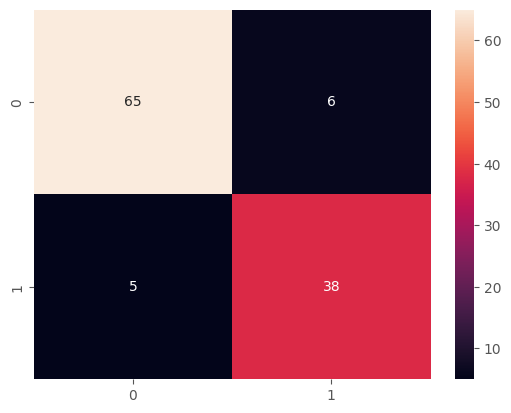

In [ ]:
# crea un nuovo oggetto DecisionTreeClassifier con i migliori iperparametri trovati
dt = DecisionTreeClassifier(criterion='entropy', max_depth=5, min_samples_split=2, min_samples_leaf=4)

# Addestra l'albero decisionale sul set di training
model2 = dt.fit(X_train_scaled, y_train)

# Effettua le previsioni sul set di test
prediction2 = model2.predict(X_test_scaled)

cm2 = confusion_matrix(y_test, prediction2)
sns.heatmap(cm2,annot=True)

In [ ]:
TP=cm2[0][0]
TN=cm2[1][1]
FN=cm2[1][0]
FP=cm2[0][1]
acc2 = (TP+TN)/(TP+TN+FN+FP)
print('Testing Accuracy:',acc2)

Testing Accuracy: 0.9035087719298246


In questo codice, utilizziamo la classe DecisionTreeClassifier della libreria scikit-learn per addestrare un albero decisionale sul set di training. Successivamente, effettuiamo le previsioni sul set di test e calcoliamo l'accuratezza delle previsioni utilizzando la funzione accuracy_score della libreria scikit-learn.

Ricorda che l'albero decisionale è un modello che può essere sensibile all'overfitting, quindi potrebbe essere utile impostare alcuni parametri per evitare l'overfitting, ad esempio impostando il parametro max_depth o min_samples_split.

In questo esempio, abbiamo impostato il parametro max_depth a 3 per evitare che l'albero cresca troppo in profondità e diventi troppo complesso. Inoltre, abbiamo impostato il parametro min_samples_split a 10 per garantire che un nodo interno possa essere diviso solo se contiene almeno 10 campioni. Questi parametri possono essere regolati per trovare il giusto equilibrio tra prestazioni e complessità del modello.

Ricorda che la scelta dei parametri dipende dal dataset specifico e potrebbe essere necessario sperimentare diverse combinazioni di parametri per trovare quelli ottimali per il tuo dataset.

In [ ]:
# Stampa la tabella di valutazione
print(classification_report(y_test, prediction2))

              precision    recall  f1-score   support

           0       0.93      0.92      0.92        71
           1       0.86      0.88      0.87        43

    accuracy                           0.90       114
   macro avg       0.90      0.90      0.90       114
weighted avg       0.90      0.90      0.90       114



In questo esempio, abbiamo utilizzato la funzione classification_report per valutare le prestazioni dell'albero decisionale sul set di test. La funzione prende in input i valori veri y_test e i valori predetti y_pred, e restituisce una tabella che riassume le metriche di valutazione per ciascuna classe (in questo caso, "maligno" e "benigno"). Le metriche includono la precisione, il richiamo, l'F1-score e il supporto.

La precisione indica la percentuale di istanze classificate come positive che sono effettivamente positive. Il richiamo indica la percentuale di istanze positive che sono state classificate correttamente. L'F1-score è una media armonica tra precisione e richiamo. Il supporto indica il numero di istanze di ciascuna classe nel set di test.

Ricorda che le metriche di valutazione dipendono dal tipo di problema che stai affrontando e dalle tue esigenze specifiche. Ad esempio, se il tuo obiettivo è identificare il maggior numero possibile di casi positivi (ad esempio, tumori maligni), potresti concentrarti sul richiamo (che indica la percentuale di casi positivi che hai identificato correttamente). Se invece vuoi minimizzare i falsi positivi (ossia, i casi che hai classificato come positivi ma che in realtà sono negativi), potresti concentrarti sulla precisione.

### **7.5 Random Forest**

Per eseguire una grid search sui parametri di una Random Forest in Scikit-Learn, puoi utilizzare la classe RandomForestClassifier insieme alla classe GridSearchCV. Ecco un esempio di come fare:

In [ ]:
# definisci i parametri da testare nella grid search
param_grid = {
    'n_estimators': [10, 50, 100, 500],
    'max_depth': [None, 2, 5, 10],
    'min_samples_split': [2, 5, 10],
    'min_samples_leaf': [1, 2, 4],
    'max_features': ['auto', 'sqrt', 'log2', None]
}

# crea un'istanza di Random Forest Classifier
rf = RandomForestClassifier(random_state=42)

# crea un'istanza di Grid Search con cross-validation
grid_search = GridSearchCV(rf, param_grid=param_grid, cv=5, n_jobs=-1)

# esegui la grid search sui dati di addestramento
grid_search.fit(X_train_scaled, y_train)

# stampa i parametri ottimali trovati dalla grid search
print("Iperparametri ottimali:\n", grid_search.best_params_)

Iperparametri ottimali:
 {'max_depth': None, 'max_features': 'auto', 'min_samples_leaf': 2, 'min_samples_split': 2, 'n_estimators': 50}


In questo esempio, n_estimators è il numero di alberi nella foresta, max_depth è la profondità massima degli alberi, min_samples_split è il numero minimo di campioni richiesti per dividere un nodo interno, min_samples_leaf è il numero minimo di campioni richiesti in un nodo foglia, e max_features è il numero massimo di feature considerate per la divisione di un nodo.

Puoi modificare la lista di iperparametri param_grid in base alle tue esigenze. Una volta eseguita la grid search, puoi utilizzare i parametri ottimali per addestrare un modello di Random Forest e valutare le sue prestazioni sui dati di test.

<Axes: >

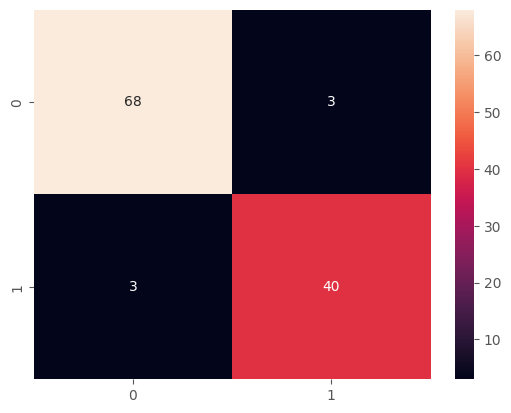

In [ ]:
# Crea il modello di Random Forest con 100 alberi
rf = RandomForestClassifier(n_estimators=50, max_depth=None, min_samples_split=2, min_samples_leaf=2, max_features='auto', random_state=42)

# Addestra il modello sul train set
model3 = rf.fit(X_train_scaled, y_train)

# Fai le predizioni sul test set
prediction3 = model3.predict(X_test_scaled)

cm3 = confusion_matrix(y_test, prediction3)
sns.heatmap(cm3,annot=True)

In [ ]:
TP=cm3[0][0]
TN=cm3[1][1]
FN=cm3[1][0]
FP=cm3[0][1]
acc3 = (TP+TN)/(TP+TN+FN+FP)
print('Testing Accuracy:',acc3)

Testing Accuracy: 0.9473684210526315


In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction3))

              precision    recall  f1-score   support

           0       0.96      0.96      0.96        71
           1       0.93      0.93      0.93        43

    accuracy                           0.95       114
   macro avg       0.94      0.94      0.94       114
weighted avg       0.95      0.95      0.95       114



In questo esempio, X_train_scaled e y_train sono i dati di addestramento precedentemente suddivisi, mentre X_test_scaled sono i dati di test scalati. Il modello viene addestrato utilizzando i migliori iperparametri trovati tramite la grid search, e le predizioni vengono effettuate sul set di test. Infine, la matrice di confusione viene visualizzata come una heatmap utilizzando la libreria Seaborn.

### **7.6 Gradient Boosting**

Gradient Boosting è un algoritmo di machine learning che si basa sull'addestramento di una sequenza di modelli di albero decisionale, ognuno dei quali cerca di migliorare la performance del modello precedente.

Ecco un esempio di come eseguire la Grid Search per trovare i migliori parametri per il modello di Gradient Boosting:

In [ ]:
# Definisci il modello di Gradient Boosting
gb = GradientBoostingClassifier()

# Definisci i valori dei parametri da testare nella Grid Search
params = {'learning_rate': [0.05, 0.1, 0.2],
          'n_estimators': [50, 100, 200],
          'max_depth': [2, 3, 4]}

# Esegui la Grid Search
grid_search = GridSearchCV(gb, params, cv=5, n_jobs=-1, verbose=1)
grid_search.fit(X_train_scaled, y_train)

# Stampa i migliori parametri trovati
print("Iperparametri ottimali:\n", grid_search.best_params_)

Fitting 5 folds for each of 27 candidates, totalling 135 fits
Iperparametri ottimali:
 {'learning_rate': 0.2, 'max_depth': 4, 'n_estimators': 50}


In questo esempio, viene definito il modello di Gradient Boosting e i valori dei parametri da testare nella Grid Search, ovvero learning_rate, n_estimators e max_depth. Viene poi eseguita la Grid Search tramite la classe GridSearchCV di sklearn.model_selection, specificando il numero di fold cv=5, il numero di job da eseguire contemporaneamente n_jobs=-1 e il livello di dettaglio della stampa verbose=1. Infine, viene stampato il dizionario dei migliori parametri trovati tramite l'attributo best_params_ dell'oggetto grid_search.

Una volta trovati i parametri ottimali, è possibile creare un nuovo modello di Gradient Boosting con i parametri trovati e addestrarlo sui dati.

<Axes: >

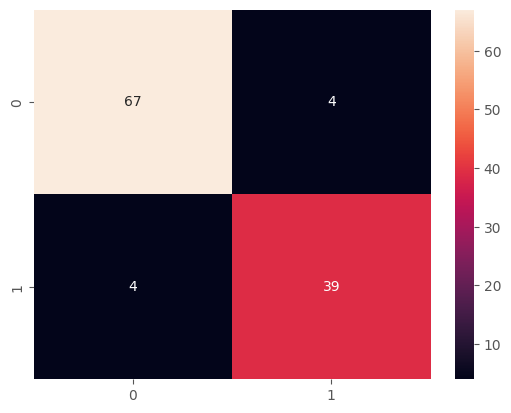

In [ ]:
# Crea il modello di Gradient Boosting con gli iperparametri ottimali
gb = GradientBoostingClassifier(learning_rate=0.2, max_depth=4, n_estimators=50, random_state=42)

# Addestra il modello sul train set
model7 = gb.fit(X_train_scaled, y_train)

# Fai le predizioni sul test set
prediction7 = model7.predict(X_test_scaled)

cm7 = confusion_matrix(y_test, prediction7)
sns.heatmap(cm7,annot=True)

Questo codice crea un modello di Gradient Boosting con gli iperparametri learning_rate=0.2, max_depth=4 e n_estimators=50, addestra il modello sui dati di training normalizzati X_train_scaled e y_train, e quindi fa le predizioni sul test set normalizzato X_test_scaled. Infine, viene calcolata la matrice di confusione e visualizzata tramite una heatmap.

In [ ]:
TP=cm7[0][0]
TN=cm7[1][1]
FN=cm7[1][0]
FP=cm7[0][1]
acc7 = (TP+TN)/(TP+TN+FN+FP)
print('Testing Accuracy:',acc7)

Testing Accuracy: 0.9298245614035088


In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction7))

              precision    recall  f1-score   support

           0       0.94      0.94      0.94        71
           1       0.91      0.91      0.91        43

    accuracy                           0.93       114
   macro avg       0.93      0.93      0.93       114
weighted avg       0.93      0.93      0.93       114



In questo esempio, il dataset è diviso in un training set e un testing set utilizzando la funzione train_test_split di scikit-learn. Successivamente, viene inizializzato il modello di Gradient Boosting con 100 alberi decisionali di profondità massima 3 e viene addestrato sul training set.

Infine, le performance del modello vengono valutate sui dati di testing utilizzando la funzione classification_report per calcolare le metriche di precisione, richiamo e F1-score, e la funzione confusion_matrix per visualizzare la matrice di confusione.

### **7.7 Naive Bayes Gaussiano**

Si tratta di un algoritmo di apprendimento automatico che utilizza il teorema di Bayes, partendo dall'ipotesi di indipendenza delle caratteristiche.
Anche se il Naïve Bayes garantisce una buona accuratezza nella classificazione, l'assunzione di indipendenza delle caratteristiche può spesso portare a errori nella pratica. Tuttavia, grazie alla sua efficienza computazionale e ad altri vantaggi, l'algoritmo Naïve Bayes è ampiamente utilizzato.

Ecco un esempio di come fare una Grid Search per ottimizzare i parametri di un modello di Naive Bayes Gaussiano:

Viene creato un oggetto GaussianNB, che rappresenta il modello di Naive Bayes Gaussiano. Viene quindi definita una griglia di parametri da testare, in questo caso priors e var_smoothing. Viene creato un oggetto GridSearchCV, che prende come argomenti il modello, la griglia di parametri e il numero di fold per la cross-validation (in questo caso cv=5). Il modello viene addestrato tramite la grid search, e infine vengono stampati i migliori parametri trovati.

In [ ]:
# Crea il modello di Naive Bayes Gaussiano
gnb = GaussianNB()

# Definisci la griglia di parametri da testare
param_grid = {
    'priors': [None, [0.25, 0.75], [0.4, 0.6]],
    'var_smoothing': [1e-9, 1e-7, 1e-5]
}

# Crea l'oggetto GridSearchCV
grid = GridSearchCV(gnb, param_grid, cv=5)

# Addestra il modello tramite la grid search
grid.fit(X_train_scaled, y_train)

# Stampa i migliori parametri trovati
print("Iperparametri ottimali:\n", grid.best_params_)

Iperparametri ottimali:
 {'priors': [0.4, 0.6], 'var_smoothing': 1e-09}


In questo esempio, viene creato un oggetto GaussianNB con il parametro priors uguale a [0.4, 0.6] ed il parametro var_smoothing impostato a 1e-9, che rappresentano i valori ottimali trovati tramite la Grid Search.
Viene quindi addestrato il modello sul train set, e infine viene fatto il confronto tra le predizioni del modello e le etichette del test set. Infine, viene visualizzata la matrice di confusione.

<Axes: >

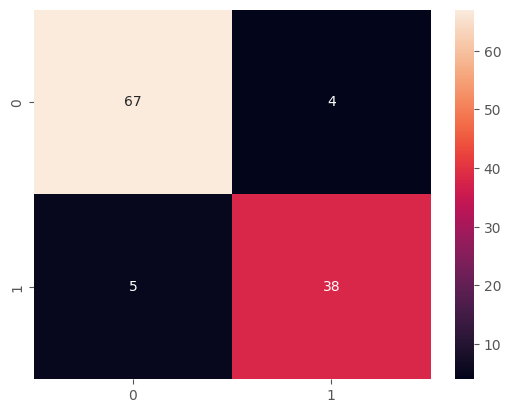

In [ ]:
# Creazione del classificatore Naive Bayes
gnb = GaussianNB(priors=[0.4, 0.6], var_smoothing=1e-9)

# Addestramento del classificatore
model6 = gnb.fit(X_train_scaled, y_train)

# Valutazione del classificatore sul test set
prediction6 = model6.predict(X_test_scaled)

cm6 = confusion_matrix(y_test, prediction6)
sns.heatmap(cm6,annot=True)

In [ ]:
TP=cm6[0][0]
TN=cm6[1][1]
FN=cm6[1][0]
FP=cm6[0][1]
acc6 = (TP+TN)/(TP+TN+FN+FP)
print('Testing Accuracy:',acc6)

Testing Accuracy: 0.9210526315789473


Infine, si calcolano le metriche di valutazione con accuracy_score, precision_score, recall_score, f1_score.

In [ ]:
# Stampa il classification report
print(classification_report(y_test, prediction6))

              precision    recall  f1-score   support

           0       0.93      0.94      0.94        71
           1       0.90      0.88      0.89        43

    accuracy                           0.92       114
   macro avg       0.92      0.91      0.92       114
weighted avg       0.92      0.92      0.92       114



### **7.8 Neural Network**

Una rete neurale artificiale (neural network) può essere un'ottima scelta per problemi di classificazione come questo, dove ci sono molte variabili che possono influenzare la diagnosi

In [ ]:
# funzione per creare il modello della rete neurale
def create_model(optimizer='adam', activation='relu', neurons=1):
    model = Sequential()
    model.add(Dense(neurons, input_dim=X_train_scaled.shape[1], activation=activation))
    model.add(Dense(1, activation='sigmoid'))
    model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])
    return model

# creazione del modello KerasClassifier
model = KerasClassifier(build_fn=create_model, verbose=0)

# definizione dei parametri per la GridSearch
optimizers = ['adam', 'sgd']
activations = ['relu', 'sigmoid', 'tanh']
neurons = [5, 10, 15, 20]


param_grid = dict(optimizer=optimizers, activation=activations, neurons=neurons)

# definizione della GridSearch
grid = GridSearchCV(estimator=model, param_grid=param_grid, n_jobs=-1, cv=5)

# addestramento della GridSearch sul train set
grid_result = grid.fit(X_train_scaled, y_train)

# stampa dei risultati
print("Iperparametri ottimali:\n", grid_result.best_params_)


In questo esempio si cerca di trovare i migliori iperparametri per la rete neurale, scegliendo il tipo di ottimizzatore (adam o sgd), la funzione di attivazione per i neuroni nascosti (relu, sigmoid o tanh) e il numero di neuroni nascosti (5, 10, o 15, 20). Il modello viene creato utilizzando la libreria Keras di TensorFlow e viene addestrato utilizzando il metodo di validazione incrociata a 5 fold. Alla fine della GridSearch, viene stampato il set di iperparametri ottimali trovati.

In [ ]:
# Crea il modello
model = Sequential()
model.add(Dense(20, input_dim=X_train_scaled.shape[1], activation='tanh'))
model.add(Dense(1, activation='sigmoid'))

# Compila il modello
optimizer = 'adam'
model.compile(loss='binary_crossentropy', optimizer=optimizer, metrics=['accuracy'])

# Addestra il modello
history = model.fit(X_train_scaled, y_train, epochs=50, batch_size=32, validation_data=(X_test_scaled, y_test))

# Valuta il modello sul test set
test_loss, test_acc = model.evaluate(X_test_scaled, y_test)

# Calcola i valori di probabilità di classe positiva per la rete neurale (per la curva ROC)
y_score_nn = model.predict(X_test_scaled)


In [ ]:
training_loss=history.history["loss"]
test_loss=history.history["val_loss"]
epoch_count=range(1,len(training_loss)+1)
plt.plot(epoch_count, training_loss, "r--")
plt.plot(epoch_count, test_loss, "b-")
plt.legend(["Training loss","Test loss"])
plt.xlabel("Epoch")
plt.ylabel("Loss")
plt.show()
print(history.history.keys())

In [ ]:
training_acc=history.history["accuracy"]
test_accu=history.history["val_accuracy"]
plt.plot(epoch_count, training_acc, "r--")
plt.plot(epoch_count, test_accu, "b-")
plt.legend(["Training accuracy","Test accuracy"])
plt.xlabel("Epoch")
plt.ylabel("Accuracy Score")
plt.show()

In [ ]:
print('Test accuracy:', test_acc)

In questo esempio, si utilizza una rete neurale con 2 hidden layer di rispettivamente 30 e 15 nodi e una funzione di attivazione ReLU, seguiti da un output layer con un singolo nodo e una funzione di attivazione sigmoide (poiché si tratta di un problema di classificazione binaria).

Si utilizza l'ottimizzatore Adam e la funzione di loss binary_crossentropy, tipiche per la classificazione binaria, e si valuta la precisione del modello durante l'addestramento e sul test set.

## **8. Valutazione dei modelli e scelta del modello migliore**

Per la valutazione dei modelli abbiamo utilizzato la curva ROC (Receiver Operating Characteristic), che è uno schema usato per confrontare gli output ottenuti da classificatori binari.

Lungo i due assi si possono rappresentare la recall e (1-(TN/(TN+FP))), rispettivamente rappresentati da True Positive Rate (TPR, frazione di veri positivi) e False Positive Rate (FPR, frazione di falsi positivi).
In altre parole, si studiano i rapporti fra istanze true positive (hit rate) e false positive.

In [ ]:
# definisci una lista di tuple con il nome del modello e il modello stesso
models = [('Modello Logit', model1), ('Albero decisionale', model2), ('Random Forest', model3), ('KNN', model4), ('SVM', model5), ('Naive Bayes Gaussiano', model6), ('Gradient Boosting', model7)]

# crea una figura vuota per la curva ROC
fig, ax = plt.subplots()

# per ogni modello nella lista
for name, model in models:
    # addestra il modello sul set di addestramento
    model.fit(X_train_scaled, y_train)

    # controlla se il modello ha il metodo predict_proba()
    if hasattr(model, "predict_proba"):
        # ottieni i valori di probabilità di classe positiva per le istanze di test
        y_score = model.predict_proba(X_test_scaled)[:, 1]
    else:
        # altrimenti, ottieni i valori delle previsioni
        y_score = model.predict(X_test_scaled)

    # calcola la curva ROC
    fpr, tpr, thresholds = roc_curve(y_test, y_score, pos_label=1)

    # calcola l'area sotto la curva ROC (AUC)
    roc_auc = auc(fpr, tpr)

    # valuta il modello sul set di test
    accuracy = model.score(X_test_scaled, y_test)

    # aggiungi la curva ROC al grafico
    ax.plot(fpr, tpr, label=f'{name} (AUC = {roc_auc:.2f})')

# Calcola la curva ROC per la rete neurale
fpr_nn, tpr_nn, thresholds_nn = roc_curve(y_test, y_score_nn, pos_label=1)

# calcola l'area sotto la curva ROC
roc_auc = auc(fpr_nn, tpr_nn)

# plotta la curva ROC
plt.plot(fpr, tpr, label=f"Neural Network (AUC = {roc_auc:.2f})", linewidth=2)

# aggiungi la legenda
plt.legend(loc="lower right")

# aggiungi la linea di riferimento per il caso casuale
ax.plot([0, 1], [0, 1], 'k--', label='Random Guess')

# personalizza il grafico
ax.set_xlabel('False Positive Rate')
ax.set_ylabel('True Positive Rate')
ax.set_title('ROC Curve')
ax.legend(loc='lower right')

# mostra il grafico
plt.show()


Andiamo infine ad osservare l'accuracy nel test di ciascun modello per confrontarli e stabilire quale sia il migliore

In [ ]:
# Grafico a linee con le accuracy dei modelli
x_labels = ['LOG_REG', 'DT','RF', 'KNN', 'SVM', 'GNB', 'GB', 'NN']
y_values = [acc1,acc2,acc3,acc4,acc5,acc6,acc7,test_acc]

acc_modelli = dict(zip(x_labels, y_values))
acc_modelli = dict(sorted(acc_modelli.items(), key=lambda item: item[1], reverse=False))
for a,b in acc_modelli.items():
    plt.text(a, b, str(round(b,3)), fontsize=12, color='dodgerblue', horizontalalignment='right', verticalalignment='bottom')

plt.plot(acc_modelli.keys(), acc_modelli.values(), marker='.', markerfacecolor='dodgerblue', markersize=12, linewidth=4)
plt.xlabel('Modelli')
plt.ylabel('Accuracy')
plt.title('Accuracy dei modelli')
plt.legend(['Modelli'], loc='lower right')
plt.show()

## **9. Conclusioni**

Alla fine della presentazione, l'intento era quello di fornire una panoramica  sui modelli di machine learning applicati alla diagnosi del cancro al seno.

Come abbiamo visto, l'utilizzo di queste tecniche può fungere da supporto all'occhio esperto del medico, consentendo una diagnosi più rapida ed efficiente, e riducendo così il rischio di false diagnosi, aumentando le possibilità di guarigione dei pazienti. Tuttavia, è importante essere consapevoli delle sfide e dei limiti dell'uso del machine learning in campo medico, come ad esempio il rischio di overfitting.

Continuando a esplorare queste tecniche e a sviluppare nuove metodologie, possiamo aprire la strada a una diagnosi ancora più accurata e personalizzata, migliorando ulteriormente la qualità della vita dei pazienti e il progresso della ricerca medica.

*All models are wrong, but some are useful.* - George E.P. Box

## **AUTORI**
*   Di Siervi Giuseppe
*   Iacuone Diego
*   Kulesko Michele
*   Moriconi Daniele
*   Nticha Sara